In [ ]:
"""
Set up the environment:

(1) pip install jupyterlab==2.2.5

(2) nodejs:
sudo apt update
curl -sL https://deb.nodesource.com/setup_10.x | sudo -E bash -
sudo apt install nodejs
node -v

(3) npm:
sudo apt-get install nodejs-dev node-gyp libssl1.0-dev
sudo apt-get install npm

If you are on MacOS: install both nodejs and npm from https://nodejs.org.en

(4) Install the extensions "toc" and "collapsible_headings" 
"""

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as ss
import itertools
import warnings
# warnings.filterwarnings('ignore') 

import seaborn as sns # If you got the error "No module named 'numpy.testing.decorators'", downgrade numpy to 1.17.0
from matplotlib import pyplot as plt

# If you encounter errors when installing xgboost:
# try to install libomp by "brew install libomp" on MacOS or install cmake by "pip3 install cmake"
# pip install xgboost==1.5.2
import xgboost as xgb

# pip install scikit-learn==0.24.2
from sklearn import tree
from sklearn.metrics import (
    mutual_info_score, confusion_matrix, 
    accuracy_score, recall_score, precision_score, 
    precision_recall_fscore_support, make_scorer, 
    plot_roc_curve, plot_precision_recall_curve, 
    classification_report, roc_auc_score, mean_squared_error
)
from sklearn.metrics.cluster import contingency_matrix
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest, RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, Ridge, Lasso, ElasticNet
from sklearn.utils.class_weight import compute_class_weight
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.svm import SVC, SVR

plt.rcParams["figure.figsize"] = (20, 20)
sns.set(rc={'figure.figsize': (20, 20)})
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
pd.set_option('display.width', 1000)
pd.set_option('max_colwidth', 100)
pd.options.mode.chained_assignment = None

def get_confusion_matrix(y_true, y_pred, n_labels):
    result = pd.DataFrame(confusion_matrix(y_true, y_pred), index=list(range(n_labels)), columns=list(range(n_labels)))
    result.index.name = 'true'
    result.columns.name = 'pred'
    return result

# Load data

In [ ]:
df = pd.read_csv('/Users/YouranQi/Documents/Career/ds_and_ml_interview/template/home_data.csv', sep=',', index_col=False)
df

In [ ]:
ignore_cols = ['id', 'zipcode', 'yr_renovated']

dt_cols = ['date']
for col in dt_cols:
    df[col] = pd.to_datetime(df[col])
    
res_cols = ['price']
df['price'] = pd.Categorical((df['price'] > df['price'].mean()).astype(int), ordered=True)

cat_cols = ['waterfront', 'view', 'condition', 'grade']
for col in cat_cols:
    df[col] = pd.Categorical(df[col], ordered=True)
    
cont_cols = [col for col in df.columns if col not in ignore_cols + dt_cols + res_cols + cat_cols]

df

# Exploratory analysis

In [ ]:
df.info()

In [ ]:
df.describe(include='all', datetime_is_numeric=True)

In [ ]:
fig, axes = plt.subplots(5, 4, figsize=(40, 35))

fig.suptitle('Plots for each individual variable')
fig.tight_layout()
fig.subplots_adjust(top=0.95)

axes = axes.flatten()
for i, col in enumerate(cat_cols + cont_cols):
    if df[col].dtype.name == 'category':
        sns.countplot(ax=axes[i], x=col, hue=res_cols[0], data=df)
    else:
        sns.histplot(ax=axes[i], x=col, hue=res_cols[0], data=df)

In [ ]:
# Given price == 0 / 1, what is the distribution of "sqft_above"?
sns.histplot(x='sqft_above', hue='price', data=df)

sqft_above
(289.999, 970.0]    0.084633
(970.0, 1120.0]     0.150988
(1120.0, 1260.0]    0.156475
(1260.0, 1400.0]    0.210624
(1400.0, 1560.0]    0.305263
(1560.0, 1760.0]    0.361712
(1760.0, 2040.0]    0.401467
(2040.0, 2410.0]    0.496732
(2410.0, 2950.0]    0.632210
(2950.0, 9410.0]    0.879310
Name: price, dtype: float64


<AxesSubplot:xlabel='sqft_above'>

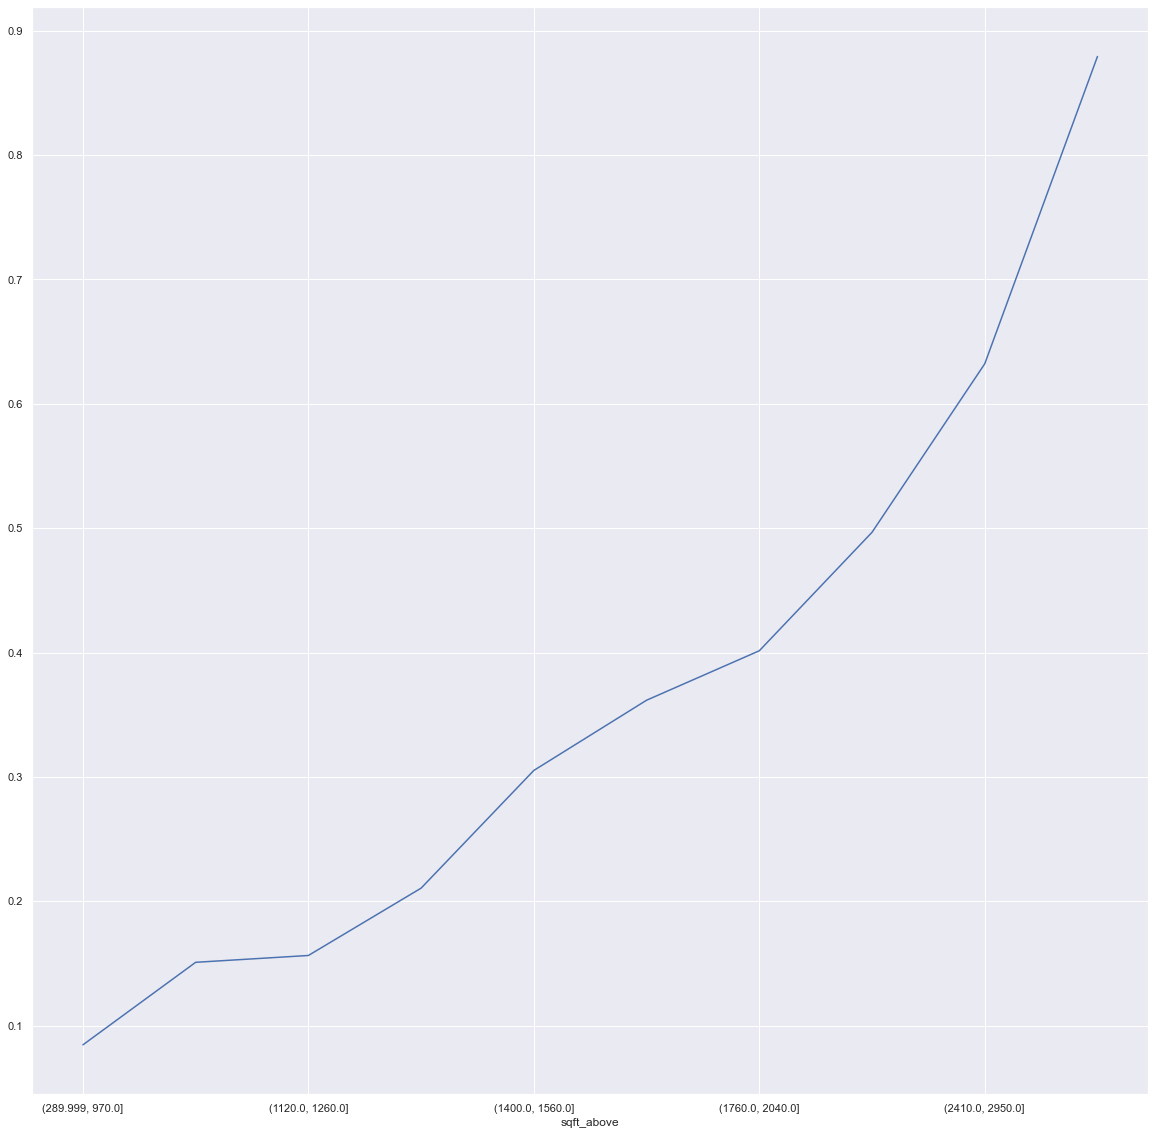

In [17]:
# Given "sqft_above" in some intervals (e.g., (289.999, 970]), what is the mean of "price" (proportion of houses with price > df['price'].mean())
# This tells us whether "sqft_above" is predictive
temp = df.groupby(pd.qcut(df['sqft_above'], q=10))['price'].apply(lambda x: x.astype(int).mean())
print(temp)
temp.plot(kind='line')

In [ ]:
confusion_table = pd.crosstab(df['grade'], df['condition'], rownames=['grade'], colnames=['condition'])
sns.heatmap(data=confusion_table, cmap='Reds', annot=True)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes = axes.flatten()
sns.regplot(ax=axes[0], x='sqft_above', y='sqft_living', data=df)
sns.lineplot(ax=axes[1], x='sqft_above', y='sqft_living', data=df, estimator=np.mean)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes = axes.flatten()
sns.boxplot(ax=axes[0], x='grade', y='sqft_living', data=df)
sns.barplot(ax=axes[1], x='grade', y='sqft_living', data=df, estimator=np.mean)

In [ ]:
sns.set(rc={'figure.figsize': (5, 5)})

df_curr = df.sample(frac=1, random_state=0).iloc[:100, :]

sns.pairplot(df_curr, hue='price')

In [ ]:
sns.set(rc={'figure.figsize': (20, 20)})

cont_cont_corr = df.corr()
sns.heatmap(cont_cont_corr, cmap='Reds', annot=True)
cont_cont_corr

## Additional

In [ ]:
sns.set(rc={'figure.figsize': (5, 5)})

df_curr = df.sample(frac=1, random_state=0).iloc[:100, :]

g = sns.PairGrid(df_curr, x_vars=cont_cols, y_vars=cont_cols, hue='price')
# g = sns.PairGrid(df_curr, x_vars=cont_cols, y_vars=cont_cols)
g.map_diag(sns.kdeplot)
g.map_lower(sns.scatterplot)
g.map_upper(sns.regplot)
g.add_legend()

In [ ]:
sns.set(rc={'figure.figsize': (5, 5)})

df_curr = df.sample(frac=1, random_state=0).iloc[:100, :]

g = sns.PairGrid(df_curr, x_vars=cat_cols, y_vars=cont_cols, hue='price')
g.map_offdiag(sns.boxplot)
g.add_legend()

In [ ]:
sns.set(rc={'figure.figsize': (5, 5)})

df_curr = df.sample(frac=1, random_state=0).iloc[:100, :]

g = sns.PairGrid(df_curr, x_vars=cat_cols, y_vars=cat_cols, hue='price')
g.map_diag(sns.countplot)
g.add_legend()

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(30, 7))

sns.scatterplot(ax=axes[0], x='sqft_above', y='sqft_living', data=df)
sns.regplot(ax=axes[1], x='sqft_above', y='sqft_living', data=df)
sns.lineplot(ax=axes[2], x='sqft_above', y='sqft_living', data=df, estimator=np.mean)

In [ ]:
fig, axes = plt.subplots(1, 6, figsize=(60, 7))

sns.swarmplot(ax=axes[0], x='grade', y='sqft_above', data=df.iloc[:100, :])  # swarmplot can't show too many points, so we select only the first 100 points
sns.stripplot(ax=axes[1], x='grade', y='sqft_above', data=df)
sns.violinplot(ax=axes[2], x='grade', y='sqft_above', data=df)
sns.boxplot(ax=axes[3], x='grade', y='sqft_above', data=df)
sns.barplot(ax=axes[4], x='grade', y='sqft_above', data=df, estimator=np.mean)
sns.barplot(ax=axes[5], x='grade', y='sqft_above', data=df, estimator=np.median)

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(30, 7))

confusion_table = pd.crosstab(df['grade'], df['condition'], rownames=['grade'], colnames=['condition'])
sns.heatmap(ax=axes[0], data=confusion_table, cmap='Reds', annot=True)

df_copy = df.copy()
df_copy['waterfront'] = df_copy['waterfront'].astype('float')
sns.barplot(ax=axes[2], x='grade', y='waterfront', data=df_copy, estimator=np.mean)

In [53]:
def chi_square(cat1, cat2, use_pvalue=True):
    confusion_table = pd.crosstab(cat1, cat2)
    return ss.chi2_contingency(confusion_table)[1] if use_pvalue else ss.chi2_contingency(confusion_table)[0]

def kruskal_wallis(cat1, cont2, use_pvalue=True):
    temp = pd.concat((cat1, cont2), axis=1)
    samples = tuple(temp.loc[temp[cat1.name] == val, cont2.name].tolist() for val in cat1.unique())
    return ss.kruskal(*samples)[1] if use_pvalue else ss.kruskal(*samples)[0]

def get_corr(df, cols1, cols2):        
    result = pd.DataFrame(index=cols1, columns=cols2)
    for col1 in cols1: 
        for col2 in cols2:
            mask = (df[col1].notnull() & df[col2].notnull())
            c1, c2 = df.loc[mask, col1], df.loc[mask, col2]
            is_cat1, is_cat2 = (c1.dtype.name == 'category'), (c2.dtype.name == 'category')
            if is_cat1 and is_cat2:
                # result.loc[col1, col2] = mutual_info_score(c1, c2)
                result.loc[col1, col2] = chi_square(c1, c2)
            elif is_cat1 and not is_cat2:
                result.loc[col1, col2] = kruskal_wallis(c1, c2)
            elif not is_cat1 and is_cat2:
                result.loc[col1, col2] = kruskal_wallis(c2, c1)
            else:
                result.loc[col1, col2] = ss.pearsonr(c1, c2)[0]
    return result.astype('float').round(5)  # Must make them float to use sns.heatmap; otherwise they are np.float64, which are not accepted by sns.heatmap

In [ ]:
sns.set(rc={'figure.figsize': (20, 20)})

cont_cont_corr = df.corr()
sns.heatmap(cont_cont_corr, cmap='Reds', annot=True)
cont_cont_corr

In [ ]:
sns.set(rc={'figure.figsize': (20, 20)})

cat_cont_corr = get_corr(df, cat_cols, cont_cols)
sns.heatmap(cat_cont_corr, cmap='Reds', annot=True)
cat_cont_corr

In [ ]:
sns.set(rc={'figure.figsize': (20, 20)})

cat_cat_corr = get_corr(df, cat_cols, cat_cols)
sns.heatmap(cat_cat_corr, cmap='Reds', annot=True)
cat_cat_corr

# Training and testing split

In [ ]:
df.loc[df.duplicated(keep=False), :]

In [ ]:
x_df = df.loc[:, cat_cols + cont_cols]
y_df = df.loc[:, res_cols]

seed = -1
while seed == -1 or any(x_train[col].nunique() != df[col].nunique() for col in cat_cols):
    seed += 1
    x_train, x_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.3, random_state=seed, stratify=y_df)
    
y_train = y_train.squeeze()
y_test = y_test.squeeze()

print(seed)
print(x_train.shape)
print(x_test.shape)
print(y_train.value_counts())
print(y_test.value_counts())

# Feature engineering

## Outlier detection and handling

In [ ]:
fig, axes = plt.subplots(len(cont_cols), 3, figsize=(30, len(cont_cols) * 7))

fig.suptitle('Plots to detect outliers for each individual continuous variable')
fig.tight_layout()
fig.subplots_adjust(top=0.95)

for i, col in enumerate(cont_cols):
    sns.boxplot(ax=axes[i][0], x=col, data=x_train)
    sns.histplot(ax=axes[i][1], x=col, data=x_train)
    sns.kdeplot(ax=axes[i][2], x=col, data=x_train, common_norm=True)

### Additional

In [ ]:
class OutlierClipper:
    def __init__(self, method):
        self.method = method
        self.bounds = dict()
        
    def fit(self, df):
        assert len(self.bounds) == 0
        
        # Make sure all columns of df are continuous variables
        for col in df.columns:
            if self.method == 'iqr':
                # See https://www.analyticsvidhya.com/blog/2021/05/feature-engineering-how-to-detect-and-remove-outliers-with-python-code/
                q25 = df[col].quantile(0.25)
                q75 = df[col].quantile(0.75)
                iqr = q75 - q25
                lb = q25 - 1.5 * iqr
                ub = q75 + 1.5 * iqr
            elif type(self.method) == tuple:
                # Winsorizing: https://en.wikipedia.org/wiki/Winsorizing
                lb = df[col].quantile(self.method[0])
                ub = df[col].quantile(self.method[1])
            else:
                raise NotImplemented
            self.bounds[col] = (lb, ub)
            
    def transform(self, df):
        assert len(self.bounds) != 0 and sorted(self.bounds.keys()) == sorted(df.columns)
        
        df_result = df.copy()
        for col in df.columns:
            lb, ub = self.bounds[col]
            df_result[col] = df[col].clip(lb, ub)
            print('{0:d} outliers for {1:} clipped'.format((~df[col].between(lb, ub)).sum(), col))
        
        return df_result

clip_cols = ['bedrooms', 'bathrooms']

outlier_clipper = OutlierClipper(method=(0.005, 0.995))
outlier_clipper.fit(x_train.loc[:, clip_cols])
x_train.loc[:, clip_cols] = outlier_clipper.transform(x_train.loc[:, clip_cols])
x_test.loc[:, clip_cols] = outlier_clipper.transform(x_test.loc[:, clip_cols])

In [ ]:
class LogTransformer:
    def __init__(self):
        self.min_val = dict()
        
    def fit(self, df):
        assert len(self.min_val) == 0        
        self.min_val = {col: df[col].min() for col in df.columns}

    def transform(self, df):
        assert len(self.min_val) != 0 and sorted(self.min_val.keys()) == sorted(df.columns)
        
        df_result = df.copy()
        for col in df.columns:
            min_val = self.min_val[col]
            if min_val <= 0:
                df_result[col] = df[col].map(lambda x: np.log(x - min_val + 1))
            else:
                df_result[col] = df[col].map(lambda x: np.log(x))
        
        return df_result

log_cols = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15']
log_transformer = LogTransformer()
log_transformer.fit(x_train.loc[:, log_cols])
x_train.loc[:, log_cols] = log_transformer.transform(x_train.loc[:, log_cols])
x_test.loc[:, log_cols] = log_transformer.transform(x_test.loc[:, log_cols])

In [ ]:
fig, axes = plt.subplots(len(cont_cols), 3, figsize=(30, len(cont_cols) * 7))

fig.suptitle('Plots for each individual continuous variable after handling outliers')
fig.tight_layout()
fig.subplots_adjust(top=0.95)

for i, col in enumerate(cont_cols):
    sns.boxplot(ax=axes[i][0], x=col, data=x_train)
    sns.histplot(ax=axes[i][1], x=col, data=x_train)
    sns.kdeplot(ax=axes[i][2], x=col, data=x_train, common_norm=True)

## Missing value

In [26]:
for col in cat_cols:
    x_train[col] = x_train[col].astype(float)
cat_imp = SimpleImputer(strategy='most_frequent')
cat_imp.fit(x_train.loc[:, cat_cols])
x_train.loc[:, cat_cols] = cat_imp.transform(x_train.loc[:, cat_cols])
for col in cat_cols:
    x_train[col] = pd.Categorical(x_train[col], ordered=True)
    
for col in cat_cols:
    x_test[col] = x_test[col].astype(float)
x_test.loc[:, cat_cols] = cat_imp.transform(x_test.loc[:, cat_cols])
for col in cat_cols:
    x_test[col] = pd.Categorical(x_test[col], ordered=True)

In [28]:
iter_imp = IterativeImputer(max_iter=10, random_state=0)
iter_imp.fit(x_train.loc[:, cont_cols])
x_train.loc[:, cont_cols] = iter_imp.transform(x_train.loc[:, cont_cols])
x_test.loc[:, cont_cols] = iter_imp.transform(x_test.loc[:, cont_cols])

### Additional

In [27]:
cont_imp = SimpleImputer(strategy='mean')
cont_imp.fit(x_train.loc[:, cont_cols])
x_train.loc[:, cont_cols] = cont_imp.transform(x_train.loc[:, cont_cols])
x_test.loc[:, cont_cols] = cont_imp.transform(x_test.loc[:, cont_cols])

## Standardization

In [29]:
scaler = StandardScaler(with_mean=True, with_std=True)
scaler.fit(x_train.loc[:, cont_cols])
x_train.loc[:, cont_cols] = scaler.transform(x_train.loc[:, cont_cols])
x_test.loc[:, cont_cols] = scaler.transform(x_test.loc[:, cont_cols])

## One-hot encoding

In [31]:
assert (x_train.columns == x_test.columns).all()
x_train_test = x_train.append(x_test)
x_train_test_dummies = pd.get_dummies(x_train_test, columns=cat_cols, drop_first=True)

x_train = x_train_test_dummies.iloc[:x_train.shape[0], :]
x_test = x_train_test_dummies.iloc[x_train.shape[0]:, :]

## PCA (optional)

In [ ]:
# PCA
pca = PCA(n_components=2)
pca.fit(x_train.loc[:, cont_cols])
x_train_pca = pd.DataFrame(pca.transform(x_train.loc[:, cont_cols]))

sns.scatterplot(x=0, y=1, data=x_train_pca)
# for i in x_train_pca.index:
#     plt.annotate(i, (x_train_pca.loc[i, 0] + 0.7, x_train_pca.loc[i, 1] + 0.7) )
    
x_train_pca

# Model training and evaluation

## Logistic regression + binary classification

### Train the model once

In [35]:
# Train the model once
"""
'newton-cg' - ['l2', 'none']
'lbfgs' - ['l2', 'none']
'liblinear' - ['l1', 'l2']
'sag' - ['l2', 'none']
'saga' - ['elasticnet', 'l1', 'l2', 'none']
"""

model = LogisticRegression(penalty='l1', C=1.0, fit_intercept=True, class_weight=None, 
                           random_state=0, solver='liblinear', max_iter=100, multi_class='ovr').fit(x_train, y_train)

print(model.score(x_train, y_train))
model.coef_

0.8452640623967216


array([[-0.16545115,  0.23711041,  0.44971236,  0.07654767,  0.23982179,
         0.52507514,  0.30030743, -1.03848517,  1.20072863,  0.09175555,
         0.70905275, -0.29255444,  2.5401772 ,  0.94493148,  0.72816145,
         1.24450791,  1.26048264,  0.        ,  0.        ,  0.3159646 ,
         0.92427259,  0.        , -1.67626291, -1.74063739, -2.56637892,
        -1.38969457,  0.        ,  1.28862423,  2.57628545,  2.3902945 ,
         0.83226619,  0.        ]])

### Train the model and search hyperparameters by CV

In [5]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_multi_metric_evaluation.html#sphx-glr-auto-examples-model-selection-plot-multi-metric-evaluation-py
# rank_test_score indicates the rank of a grid search parameter combination based on the mean_test_score

param_grid = [
    {'penalty': ['l1', 'l2'], 'solver': ['liblinear'], 'C': [100, 10, 5, 2, 1], 'class_weight': [{0: 1.2, 1: 1.0}, 'balanced']},
    {'penalty': ['none'], 'solver': ['newton-cg'], 'C': [100, 10, 5, 2, 1], 'class_weight': [{0: 1.2, 1: 1.0}, 'balanced']}
]

accuracy_scorer = make_scorer(accuracy_score)
precision_scorer = make_scorer(precision_score, pos_label=1, average='binary')
recall_scorer = make_scorer(recall_score, pos_label=1, average='binary')
scoring = {'AUC': 'roc_auc', 'Accuracy': accuracy_scorer, 'Precision': precision_scorer, 'Recall': recall_scorer}

gs = GridSearchCV(
    LogisticRegression(random_state=0),
    param_grid=param_grid,
    scoring=scoring,
    refit='AUC',
    return_train_score=False,
    cv=5, n_jobs=-1
)
gs.fit(x_train, y_train)

# rs = RandomizedSearchCV(
#     LogisticRegression(random_state=0),
#     param_distributions=param_grid,
#     n_iter=15,
#     scoring=scoring,
#     refit='AUC',
#     return_train_score=False,
#     cv=5, n_jobs=-1, random_state=0
# )
# rs.fit(x_train, y_train)

model = gs.best_estimator_
print(gs.best_estimator_)
print(gs.best_params_)

result = gs.cv_results_
list(result.keys())

LogisticRegression(C=100, class_weight='balanced', penalty='l1', random_state=0,
                   solver='liblinear')
{'C': 100, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'liblinear'}


['mean_fit_time',
 'std_fit_time',
 'mean_score_time',
 'std_score_time',
 'param_C',
 'param_class_weight',
 'param_penalty',
 'param_solver',
 'params',
 'split0_test_AUC',
 'split1_test_AUC',
 'split2_test_AUC',
 'split3_test_AUC',
 'split4_test_AUC',
 'mean_test_AUC',
 'std_test_AUC',
 'rank_test_AUC',
 'split0_test_Accuracy',
 'split1_test_Accuracy',
 'split2_test_Accuracy',
 'split3_test_Accuracy',
 'split4_test_Accuracy',
 'mean_test_Accuracy',
 'std_test_Accuracy',
 'rank_test_Accuracy',
 'split0_test_Precision',
 'split1_test_Precision',
 'split2_test_Precision',
 'split3_test_Precision',
 'split4_test_Precision',
 'mean_test_Precision',
 'std_test_Precision',
 'rank_test_Precision',
 'split0_test_Recall',
 'split1_test_Recall',
 'split2_test_Recall',
 'split3_test_Recall',
 'split4_test_Recall',
 'mean_test_Recall',
 'std_test_Recall',
 'rank_test_Recall']

In [37]:
df_params = pd.DataFrame(result['params'])
df_metrics = pd.DataFrame({k: result[k] for k in ['mean_test_AUC', 'std_test_AUC', 'mean_test_Accuracy', 'std_test_Accuracy', 'mean_test_Precision', 'std_test_Precision', 'mean_test_Recall', 'std_test_Recall']})
df_cv = pd.concat((df_params, df_metrics), axis=1).sort_values(by=['mean_test_AUC', 'mean_test_Accuracy', 'mean_test_Precision', 'mean_test_Recall'], ascending=False)
df_cv

,C,class_weight,penalty,solver,mean_test_AUC,std_test_AUC,mean_test_Accuracy,std_test_Accuracy,mean_test_Precision,std_test_Precision,mean_test_Recall,std_test_Recall
2,100,balanced,l1,liblinear,0.927007,0.005622,0.840769,0.005167,0.795099,0.008593,0.836899,0.006352
3,100,balanced,l2,liblinear,0.927005,0.005631,0.840637,0.005149,0.795038,0.008570,0.836584,0.006560
6,10,balanced,l1,liblinear,0.927004,0.005602,0.840637,0.004861,0.794942,0.008129,0.836742,0.006370
21,100,balanced,none,newton-cg,0.927003,0.005638,0.840703,0.005368,0.795157,0.008758,0.836584,0.006749
23,10,balanced,none,newton-cg,0.927003,0.005638,0.840703,0.005368,0.795157,0.008758,0.836584,0.006749
25,5,balanced,none,newton-cg,0.927003,0.005638,0.840703,0.005368,0.795157,0.008758,0.836584,0.006749
27,2,balanced,none,newton-cg,0.927003,0.005638,0.840703,0.005368,0.795157,0.008758,0.836584,0.006749
29,1,balanced,none,newton-cg,0.927003,0.005638,0.840703,0.005368,0.795157,0.008758,0.836584,0.006749
7,10,balanced,l2,liblinear,0.926997,0.005617,0.840703,0.005088,0.795070,0.008554,0.836742,0.006370
11,5,balanced,l2,liblinear,0.926984,0.005604,0.840835,0.004844,0.795128,0.008263,0.837056,0.006520


### Evaluation

In [38]:
proba_pred = model.predict_proba(x_test)
y_pred = model.predict(x_test)
acc_test = model.score(x_test, y_test)

assert (proba_pred.argmax(axis=1) == y_pred).all()
assert acc_test == accuracy_score(y_test, y_pred) == (y_test == pd.Series(y_pred)).mean()

In [ ]:
print(classification_report(y_test, y_pred, target_names=['class 0', 'class 1']))

In [ ]:
get_confusion_matrix(y_test, y_pred, n_labels=2)

In [ ]:
plot_roc_curve(model, x_test, y_test)

In [ ]:
plot_precision_recall_curve(model, x_test, y_test)

## Random forest + binary classification

### Train the model once

In [ ]:
# Train the model once
model = RandomForestClassifier(n_estimators=100, 
                               criterion='gini',
                               max_depth=3, # Avoid overfitting by controling the complexity of the tree
                               max_leaf_nodes=None, # Avoid overfitting by controling the complexity of the tree
                               ccp_alpha=0.0, # Avoid overfitting by pruning the tree
                               min_samples_split=2, # Avoid overfitting by avoid splitting too much
                               min_samples_leaf=1, # Avoid overfitting by avoid splitting too much
                               min_weight_fraction_leaf=0.0, # Avoid overfitting by avoid splitting too much
                               min_impurity_decrease=0.0, # Avoid overfitting by avoid splitting too much
                               max_features='sqrt', # Make sure trees are independent
                               bootstrap=True, # Make sure trees are independent
                               max_samples=None, # Make sure trees are independent
                               oob_score=True,
                               class_weight='balanced',
                               n_jobs=-1,
                               random_state=0).fit(x_train, y_train)

print(model.score(x_train, y_train))
tree.plot_tree(model.estimators_[0], feature_names=x_train.columns)  # Visualize one of the trees in the random forest
plt.show()

In [ ]:
df_importance = pd.concat((pd.Series(x_train.columns), pd.Series(model.feature_importances_)), axis=1)
df_importance.columns = ['feature', 'importance_score']
df_importance = df_importance.sort_values(by='importance_score', ascending=False)
df_importance.plot(x='feature', y='importance_score', kind='bar', figsize=(20, 10))
df_importance

### Train the model and search hyperparameters by CV

In [ ]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_multi_metric_evaluation.html#sphx-glr-auto-examples-model-selection-plot-multi-metric-evaluation-py
# rank_test_score indicates the rank of a grid search parameter combination based on the mean_test_score

param_grid = [
    {'n_estimators': [100, 200], 
     'criterion': ['gini', 'entropy'], 
     'max_depth': [3, 6], 
     'min_samples_split': [2, 10],
     'min_samples_leaf': [1, 5],
     'min_impurity_decrease': [0, 0.02],
     'class_weight': [{0: 1.2, 1: 1.0}, 'balanced']}
]

accuracy_scorer = make_scorer(accuracy_score)
precision_scorer = make_scorer(precision_score, pos_label=1, average='binary')
recall_scorer = make_scorer(recall_score, pos_label=1, average='binary')
scoring = {'AUC': 'roc_auc', 'Accuracy': accuracy_scorer, 'Precision': precision_scorer, 'Recall': recall_scorer}

# gs = GridSearchCV(
#     RandomForestClassifier(random_state=0),
#     param_grid=param_grid,
#     scoring=scoring,
#     refit='AUC',
#     return_train_score=False,
#     cv=5, n_jobs=-1
# )
# gs.fit(x_train, y_train)

rs = RandomizedSearchCV(
    RandomForestClassifier(random_state=0),
    param_distributions=param_grid,
    n_iter=30,
    scoring=scoring,
    refit='AUC',
    return_train_score=False,
    cv=5, n_jobs=-1, random_state=0
)
rs.fit(x_train, y_train)

model = rs.best_estimator_
print(rs.best_estimator_)
print(rs.best_params_)

result = rs.cv_results_
list(result.keys())

In [9]:
df_params = pd.DataFrame(result['params'])
df_metrics = pd.DataFrame({k: result[k] for k in ['mean_test_AUC', 'std_test_AUC', 'mean_test_Accuracy', 'std_test_Accuracy', 'mean_test_Precision', 'std_test_Precision', 'mean_test_Recall', 'std_test_Recall']})
df_cv = pd.concat((df_params, df_metrics), axis=1).sort_values(by=['mean_test_AUC', 'mean_test_Accuracy', 'mean_test_Precision', 'mean_test_Recall'], ascending=False)
df_cv

,n_estimators,min_samples_split,min_samples_leaf,min_impurity_decrease,max_depth,criterion,class_weight,mean_test_AUC,std_test_AUC,mean_test_Accuracy,std_test_Accuracy,mean_test_Precision,std_test_Precision,mean_test_Recall,std_test_Recall
2,100,10,5,0.00,6,gini,balanced,0.959170,0.003620,0.888096,0.005944,0.858222,0.009728,0.879051,0.006345
3,200,10,1,0.00,6,entropy,"{0: 1.2, 1: 1.0}",0.958411,0.003353,0.881090,0.005441,0.904196,0.010039,0.802138,0.008348
29,100,10,5,0.00,6,entropy,balanced,0.958375,0.003545,0.886840,0.005683,0.856149,0.009186,0.878422,0.005759
27,100,2,1,0.00,6,gini,"{0: 1.2, 1: 1.0}",0.958297,0.003624,0.881354,0.005945,0.907593,0.010190,0.799149,0.010602
22,100,2,1,0.00,6,entropy,"{0: 1.2, 1: 1.0}",0.958272,0.003383,0.879900,0.006859,0.905008,0.010339,0.798048,0.010997
20,100,10,5,0.00,6,gini,"{0: 1.2, 1: 1.0}",0.958120,0.003694,0.880759,0.006485,0.905259,0.009841,0.800094,0.012854
18,100,10,1,0.00,6,entropy,"{0: 1.2, 1: 1.0}",0.957996,0.003070,0.880032,0.006142,0.903753,0.009297,0.799778,0.011378
23,100,2,5,0.00,3,gini,balanced,0.933759,0.004880,0.851544,0.005514,0.829573,0.008969,0.814092,0.007656
21,200,2,5,0.00,3,entropy,balanced,0.932224,0.005068,0.843877,0.008521,0.814251,0.014088,0.814564,0.007405
7,100,2,1,0.00,3,entropy,balanced,0.932115,0.005120,0.844670,0.007984,0.816319,0.012537,0.813621,0.006527


### Evaluation

In [10]:
proba_pred = model.predict_proba(x_test)
y_pred = model.predict(x_test)
acc_test = model.score(x_test, y_test)

assert (proba_pred.argmax(axis=1) == y_pred).all()
assert acc_test == accuracy_score(y_test, y_pred) == (y_test == pd.Series(y_pred)).mean()

In [ ]:
print(classification_report(y_test, y_pred, target_names=['class 0', 'class 1']))

In [ ]:
get_confusion_matrix(y_test, y_pred, n_labels=2)

In [ ]:
plot_roc_curve(model, x_test, y_test)

In [ ]:
plot_precision_recall_curve(model, x_test, y_test)

## GBDT + binary classification

### Train the model once

0.9146010972304845


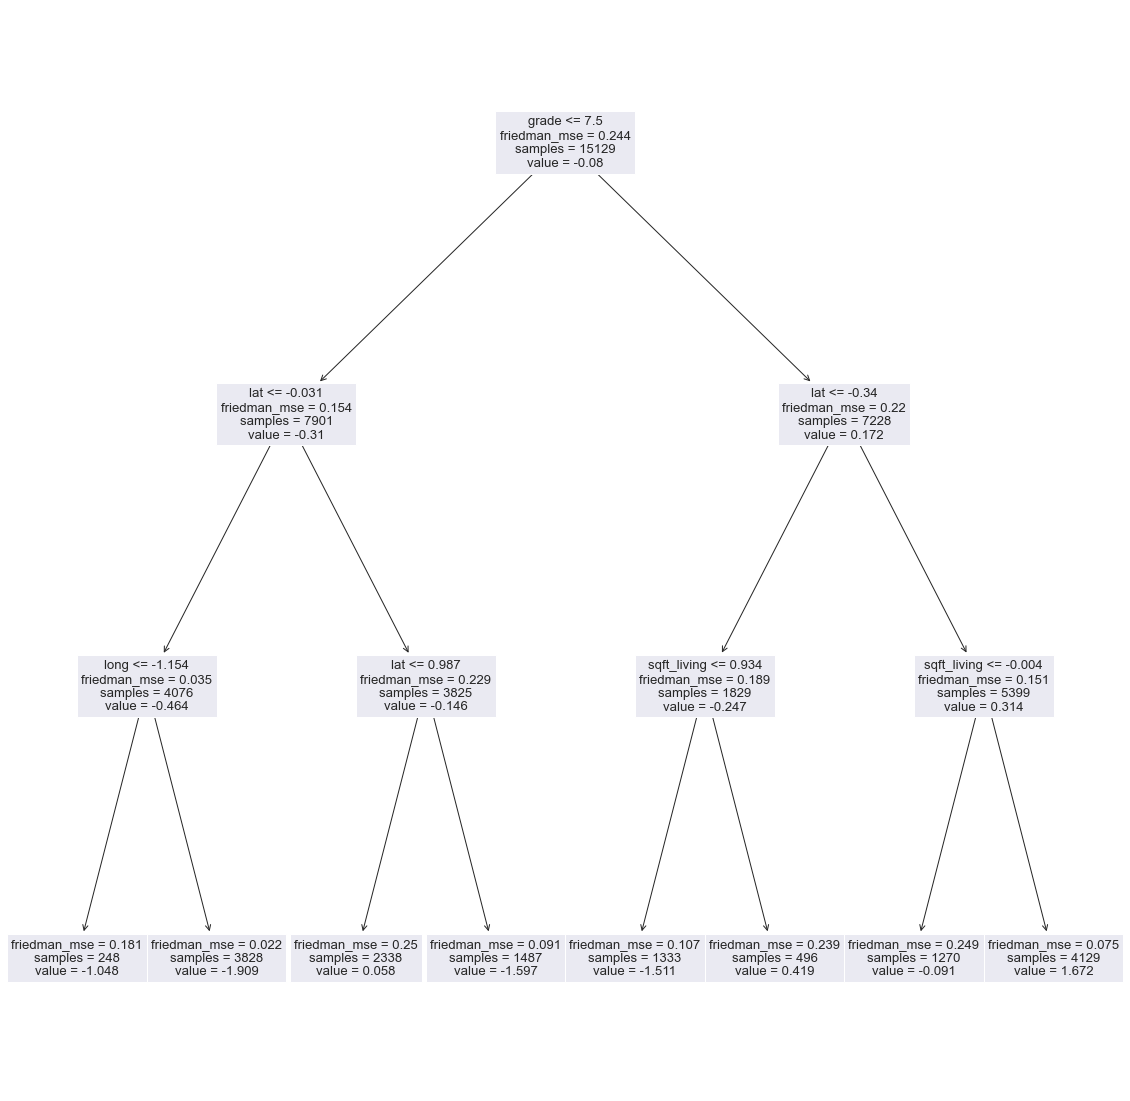

In [8]:
# Train the model once
model = GradientBoostingClassifier(loss='deviance',  # binomial or multinomial deviance loss function
                                   learning_rate=0.1, # Learning rate shrinks the contribution of each tree by learning_rate. The larger the learning rate is, the fewer estimators we need
                                   n_estimators=100, # Gradient boosting is fairly robust to over-fitting so a large number usually results in better performance
                                   criterion='friedman_mse',
                                   init='zero', # An estimator object that is used to compute the initial predictions
                                   max_depth=3, # Avoid overfitting by controling the complexity of the tree
                                   max_leaf_nodes=None, # Avoid overfitting by controling the complexity of the tree
                                   ccp_alpha=0.0, # Avoid overfitting by pruning the tree
                                   min_samples_split=2, # Avoid overfitting by avoid splitting too much
                                   min_samples_leaf=1, # Avoid overfitting by avoid splitting too much
                                   min_weight_fraction_leaf=0.0, # Avoid overfitting by avoid splitting too much
                                   min_impurity_decrease=0.0, # Avoid overfitting by avoid splitting too much
                                   subsample=1.0,  # The fraction of samples to be used for fitting the individual base learners. If smaller than 1.0 this results in Stochastic Gradient Boosting. subsample interacts with the parameter n_estimators. Choosing subsample < 1.0 leads to a reduction of variance and an increase in bias
                                   max_features=None, # Make sure trees are independent
                                   random_state=0).fit(x_train, y_train)  # Unlike Random Forest, there is no "class_weight" in model, we only have "sample_weight" in fit (see https://scikit-learn.org/0.24/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier.fit)

print(model.score(x_train, y_train))
tree.plot_tree(model.estimators_[0][0], feature_names=x_train.columns)  # Visualize one of the trees in the random forest, where now model.estimators_ is an array of size n_estimators * loss_.K
plt.show()

,feature,importance_score
12,lat,0.391886
3,grade,0.248901
6,sqft_living,0.236311
14,sqft_living15,0.030457
15,sqft_lot15,0.018644
11,yr_built,0.017659
13,long,0.015841
7,sqft_lot,0.012099
9,sqft_above,0.010403
1,view,0.009922


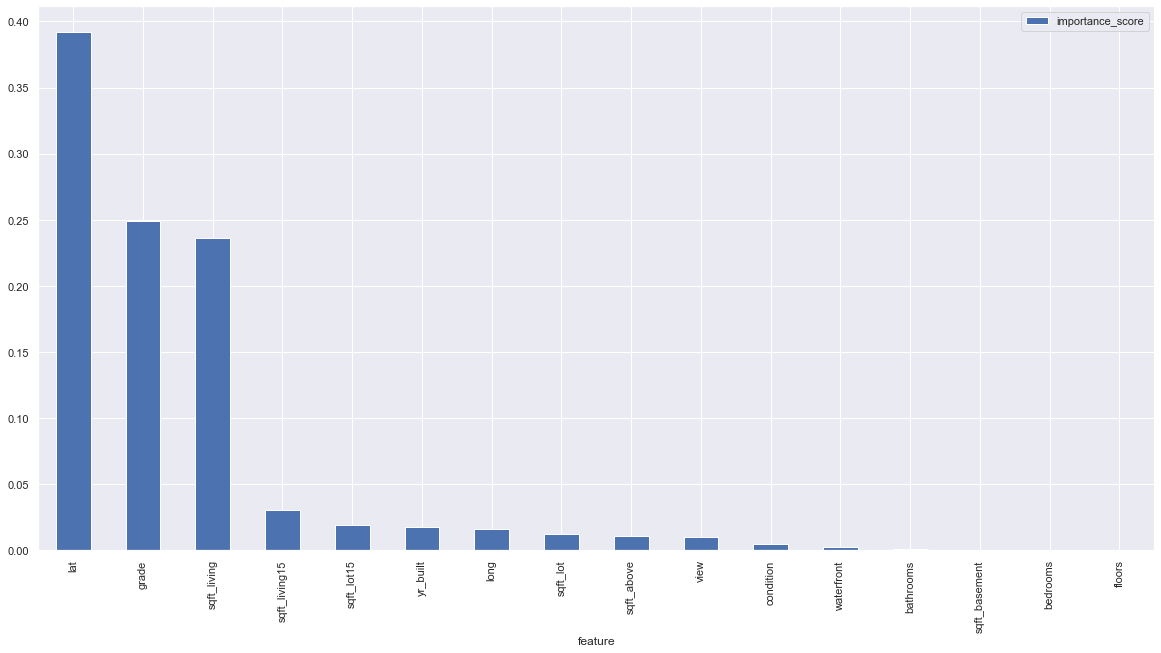

In [9]:
df_importance = pd.concat((pd.Series(x_train.columns), pd.Series(model.feature_importances_)), axis=1)
df_importance.columns = ['feature', 'importance_score']
df_importance = df_importance.sort_values(by='importance_score', ascending=False)
df_importance.plot(x='feature', y='importance_score', kind='bar', figsize=(20, 10))
df_importance

### Train the model and search hyperparameters by CV

In [8]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_multi_metric_evaluation.html#sphx-glr-auto-examples-model-selection-plot-multi-metric-evaluation-py
# rank_test_score indicates the rank of a grid search parameter combination based on the mean_test_score

param_grid = [
    {'learning_rate': [0.01, 0.1],
     'n_estimators': [50, 100], 
     'max_depth': [3, 6], 
     'min_samples_split': [2, 10],
     'min_samples_leaf': [1, 5],
     'min_impurity_decrease': [0, 0.02], 
     'subsample': [1, 0.8]}
]

accuracy_scorer = make_scorer(accuracy_score)
precision_scorer = make_scorer(precision_score, pos_label=1, average='binary')
recall_scorer = make_scorer(recall_score, pos_label=1, average='binary')
scoring = {'AUC': 'roc_auc', 'Accuracy': accuracy_scorer, 'Precision': precision_scorer, 'Recall': recall_scorer}

rs = RandomizedSearchCV(
    GradientBoostingClassifier(random_state=0),
    param_distributions=param_grid,
    n_iter=10,
    scoring=scoring,
    refit='AUC',
    return_train_score=False,
    cv=5, n_jobs=-1, random_state=0
)
rs.fit(x_train, y_train)

model = rs.best_estimator_
print(rs.best_estimator_)
print(rs.best_params_)

result = rs.cv_results_
list(result.keys())

GradientBoostingClassifier(max_depth=6, min_impurity_decrease=0.02,
                           min_samples_leaf=5, min_samples_split=10,
                           random_state=0, subsample=0.8)
{'subsample': 0.8, 'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 5, 'min_impurity_decrease': 0.02, 'max_depth': 6, 'learning_rate': 0.1}


['mean_fit_time',
 'std_fit_time',
 'mean_score_time',
 'std_score_time',
 'param_subsample',
 'param_n_estimators',
 'param_min_samples_split',
 'param_min_samples_leaf',
 'param_min_impurity_decrease',
 'param_max_depth',
 'param_learning_rate',
 'params',
 'split0_test_AUC',
 'split1_test_AUC',
 'split2_test_AUC',
 'split3_test_AUC',
 'split4_test_AUC',
 'mean_test_AUC',
 'std_test_AUC',
 'rank_test_AUC',
 'split0_test_Accuracy',
 'split1_test_Accuracy',
 'split2_test_Accuracy',
 'split3_test_Accuracy',
 'split4_test_Accuracy',
 'mean_test_Accuracy',
 'std_test_Accuracy',
 'rank_test_Accuracy',
 'split0_test_Precision',
 'split1_test_Precision',
 'split2_test_Precision',
 'split3_test_Precision',
 'split4_test_Precision',
 'mean_test_Precision',
 'std_test_Precision',
 'rank_test_Precision',
 'split0_test_Recall',
 'split1_test_Recall',
 'split2_test_Recall',
 'split3_test_Recall',
 'split4_test_Recall',
 'mean_test_Recall',
 'std_test_Recall',
 'rank_test_Recall']

In [9]:
df_params = pd.DataFrame(result['params'])
df_metrics = pd.DataFrame({k: result[k] for k in ['mean_test_AUC', 'std_test_AUC', 'mean_test_Accuracy', 'std_test_Accuracy', 'mean_test_Precision', 'std_test_Precision', 'mean_test_Recall', 'std_test_Recall']})
df_cv = pd.concat((df_params, df_metrics), axis=1).sort_values(by=['mean_test_AUC', 'mean_test_Accuracy', 'mean_test_Precision', 'mean_test_Recall'], ascending=False)
df_cv

,subsample,n_estimators,min_samples_split,min_samples_leaf,min_impurity_decrease,max_depth,learning_rate,mean_test_AUC,std_test_AUC,mean_test_Accuracy,std_test_Accuracy,mean_test_Precision,std_test_Precision,mean_test_Recall,std_test_Recall
6,0.8,100,10,5,0.02,6,0.10,0.972783,0.002318,0.909049,0.006732,0.894477,0.012980,0.888643,0.008892
5,1.0,50,10,5,0.00,6,0.10,0.970909,0.002522,0.907661,0.005982,0.891948,0.011472,0.888015,0.005896
7,1.0,50,2,1,0.00,6,0.10,0.970501,0.002200,0.907066,0.006434,0.890547,0.011539,0.888173,0.006036
2,1.0,100,10,1,0.02,3,0.10,0.968445,0.002234,0.901844,0.004491,0.889006,0.009134,0.875904,0.004441
8,0.8,50,2,5,0.00,3,0.10,0.964918,0.002660,0.896953,0.004781,0.888331,0.010089,0.863479,0.005145
3,0.8,100,2,1,0.02,6,0.01,0.963946,0.003366,0.894375,0.006104,0.895701,0.010400,0.847435,0.006963
0,1.0,50,2,5,0.00,6,0.01,0.958601,0.004171,0.882610,0.007397,0.908151,0.010592,0.801822,0.012098
9,0.8,100,10,1,0.00,3,0.01,0.948338,0.004314,0.869324,0.006878,0.891999,0.007558,0.784046,0.016789
1,1.0,50,2,5,0.02,3,0.01,0.940782,0.005569,0.831251,0.007206,0.927481,0.009776,0.649258,0.014919
4,1.0,50,2,5,0.00,3,0.01,0.940782,0.005569,0.831251,0.007206,0.927481,0.009776,0.649258,0.014919


### Evaluation

In [10]:
proba_pred = model.predict_proba(x_test)
y_pred = model.predict(x_test)
acc_test = model.score(x_test, y_test)

assert (proba_pred.argmax(axis=1) == y_pred).all()
assert acc_test == accuracy_score(y_test, y_pred) == (y_test == pd.Series(y_pred)).mean()

In [ ]:
print(classification_report(y_test, y_pred, target_names=['class 0', 'class 1']))

In [ ]:
get_confusion_matrix(y_test, y_pred, n_labels=2)

In [ ]:
plot_roc_curve(model, x_test, y_test)

In [ ]:
plot_precision_recall_curve(model, x_test, y_test)

## Logistic regression + multiple classification

### Train the model once

In [5]:
# Train the model once
model = LogisticRegression(penalty='l1', C=1.0, fit_intercept=True, class_weight=None, 
                           random_state=0, solver='saga', tol=5e-3, max_iter=200, multi_class='multinomial').fit(x_train, y_train)

print(model.score(x_train, y_train))
model.coef_

0.7373256659395863


array([[ 1.50387299e-01, -3.75941568e-01, -6.33590967e-02,
        -2.94422143e-01, -2.93095411e-01, -5.73678867e-01,
        -4.22772357e-01,  6.60364387e-01, -1.63261420e+00,
        -1.31827964e-01, -6.46792870e-01,  1.60644610e-01,
        -1.94609326e+00, -4.57084706e-01, -9.07478248e-01,
        -1.77086517e+00, -2.17790683e+00,  0.00000000e+00,
        -6.73759883e-02, -5.25537715e-01, -9.38857878e-01,
         0.00000000e+00,  1.35386265e+00,  1.51995046e+00,
         1.20531561e+00,  3.76289069e-01, -4.55360155e-01,
        -2.00293890e+00, -2.48324037e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.72353600e-02,  0.00000000e+00, -1.38421333e-05,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         7.07312659e-02,  0.00000000e+00, -4.27864206e-02,
         1.70

### Train the model and search hyperparameters by CV

In [6]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_multi_metric_evaluation.html#sphx-glr-auto-examples-model-selection-plot-multi-metric-evaluation-py
# rank_test_score indicates the rank of a grid search parameter combination based on the mean_test_score

param_grid = [
    {'penalty': ['l1'], 'solver': ['saga'], 'C': [100, 10, 5, 2, 1], 'class_weight': [{0: 1.2, 1: 1.0, 2: 2.0}, 'balanced']},
    {'penalty': ['l2', 'none'], 'solver': ['newton-cg'], 'C': [100, 10, 5, 2, 1], 'class_weight': [{0: 1.2, 1: 1.0, 2: 2.0}, 'balanced']}
]

def precision_2(y_true, y_pred):
    return precision_score(y_true, y_pred, average=None)[2]
def recall_2(y_true, y_pred):
    return recall_score(y_true, y_pred, average=None)[2]
def multiclass_auc(y_true, y_prob):
    return roc_auc_score(y_true, y_prob, multi_class='ovo', average='macro')
auc_scorer = make_scorer(multiclass_auc, needs_proba=True, greater_is_better=True)  # multiclass_auc requires to accept y_prob as input, so we need to set needs_proba=True
accuracy_scorer = make_scorer(accuracy_score, greater_is_better=True)
precision_scorer = make_scorer(precision_2, greater_is_better=True)
recall_scorer = make_scorer(recall_2, greater_is_better=True)
scoring = {'AUC': auc_scorer, 'Accuracy': accuracy_scorer, 'Precision': precision_scorer, 'Recall': recall_scorer}

rs = RandomizedSearchCV(
    LogisticRegression(tol=5e-3, max_iter=200, multi_class='multinomial', random_state=0),
    param_distributions=param_grid,
    n_iter=15,
    scoring=scoring,
    refit='AUC',
    return_train_score=False,
    cv=5, n_jobs=-1, random_state=0
)
rs.fit(x_train, y_train)

model = rs.best_estimator_
print(rs.best_estimator_)
print(rs.best_params_)

result = rs.cv_results_
list(result.keys())

LogisticRegression(C=2, class_weight='balanced', max_iter=200,
                   multi_class='multinomial', random_state=0,
                   solver='newton-cg', tol=0.005)
{'solver': 'newton-cg', 'penalty': 'l2', 'class_weight': 'balanced', 'C': 2}


['mean_fit_time',
 'std_fit_time',
 'mean_score_time',
 'std_score_time',
 'param_solver',
 'param_penalty',
 'param_class_weight',
 'param_C',
 'params',
 'split0_test_AUC',
 'split1_test_AUC',
 'split2_test_AUC',
 'split3_test_AUC',
 'split4_test_AUC',
 'mean_test_AUC',
 'std_test_AUC',
 'rank_test_AUC',
 'split0_test_Accuracy',
 'split1_test_Accuracy',
 'split2_test_Accuracy',
 'split3_test_Accuracy',
 'split4_test_Accuracy',
 'mean_test_Accuracy',
 'std_test_Accuracy',
 'rank_test_Accuracy',
 'split0_test_Precision',
 'split1_test_Precision',
 'split2_test_Precision',
 'split3_test_Precision',
 'split4_test_Precision',
 'mean_test_Precision',
 'std_test_Precision',
 'rank_test_Precision',
 'split0_test_Recall',
 'split1_test_Recall',
 'split2_test_Recall',
 'split3_test_Recall',
 'split4_test_Recall',
 'mean_test_Recall',
 'std_test_Recall',
 'rank_test_Recall']

In [7]:
df_params = pd.DataFrame(result['params'])
df_metrics = pd.DataFrame({k: result[k] for k in ['mean_test_AUC', 'std_test_AUC', 'mean_test_Accuracy', 'std_test_Accuracy', 'mean_test_Precision', 'std_test_Precision', 'mean_test_Recall', 'std_test_Recall']})
df_cv = pd.concat((df_params, df_metrics), axis=1).sort_values(by=['mean_test_AUC', 'mean_test_Accuracy', 'mean_test_Precision', 'mean_test_Recall'], ascending=False)
df_cv

,solver,penalty,class_weight,C,mean_test_AUC,std_test_AUC,mean_test_Accuracy,std_test_Accuracy,mean_test_Precision,std_test_Precision,mean_test_Recall,std_test_Recall
5,newton-cg,l2,balanced,2,0.893487,0.002653,0.736135,0.005113,0.810757,0.008905,0.764557,0.006707
10,saga,l1,balanced,5,0.893478,0.002659,0.736268,0.004978,0.811046,0.008930,0.764364,0.006844
1,newton-cg,l2,balanced,1,0.893460,0.002632,0.735871,0.005864,0.810336,0.009694,0.764944,0.006967
11,newton-cg,l2,balanced,10,0.893450,0.002702,0.736268,0.005180,0.811310,0.009728,0.763977,0.006994
2,newton-cg,none,balanced,100,0.893366,0.002755,0.736069,0.005353,0.811257,0.009292,0.763784,0.006759
8,newton-cg,none,balanced,10,0.893366,0.002755,0.736069,0.005353,0.811257,0.009292,0.763784,0.006759
9,newton-cg,l2,"{0: 1.2, 1: 1.0, 2: 2.0}",2,0.893072,0.002631,0.718950,0.006034,0.711515,0.010255,0.877928,0.009243
0,saga,l1,"{0: 1.2, 1: 1.0, 2: 2.0}",10,0.893066,0.002643,0.719346,0.006236,0.712309,0.010842,0.877928,0.008527
4,newton-cg,l2,"{0: 1.2, 1: 1.0, 2: 2.0}",1,0.893051,0.002595,0.718752,0.005799,0.711043,0.010003,0.878315,0.009636
13,newton-cg,l2,"{0: 1.2, 1: 1.0, 2: 2.0}",10,0.893046,0.002667,0.719280,0.005779,0.711849,0.010406,0.877928,0.008999


### Evaluation

In [ ]:
proba_pred = model.predict_proba(x_test)
y_pred = model.predict(x_test)
acc_test = model.score(x_test, y_test)

assert (proba_pred.argmax(axis=1) == y_pred).all()
assert acc_test == accuracy_score(y_test, y_pred) == (y_test == pd.Series(y_pred)).mean()

In [ ]:
print(classification_report(y_test, y_pred, target_names=['class 0', 'class 1', 'class 2']))

In [ ]:
get_confusion_matrix(y_test, y_pred, n_labels=3)

## Random forest + multiple classification

### Train the model once

0.7260889682067553


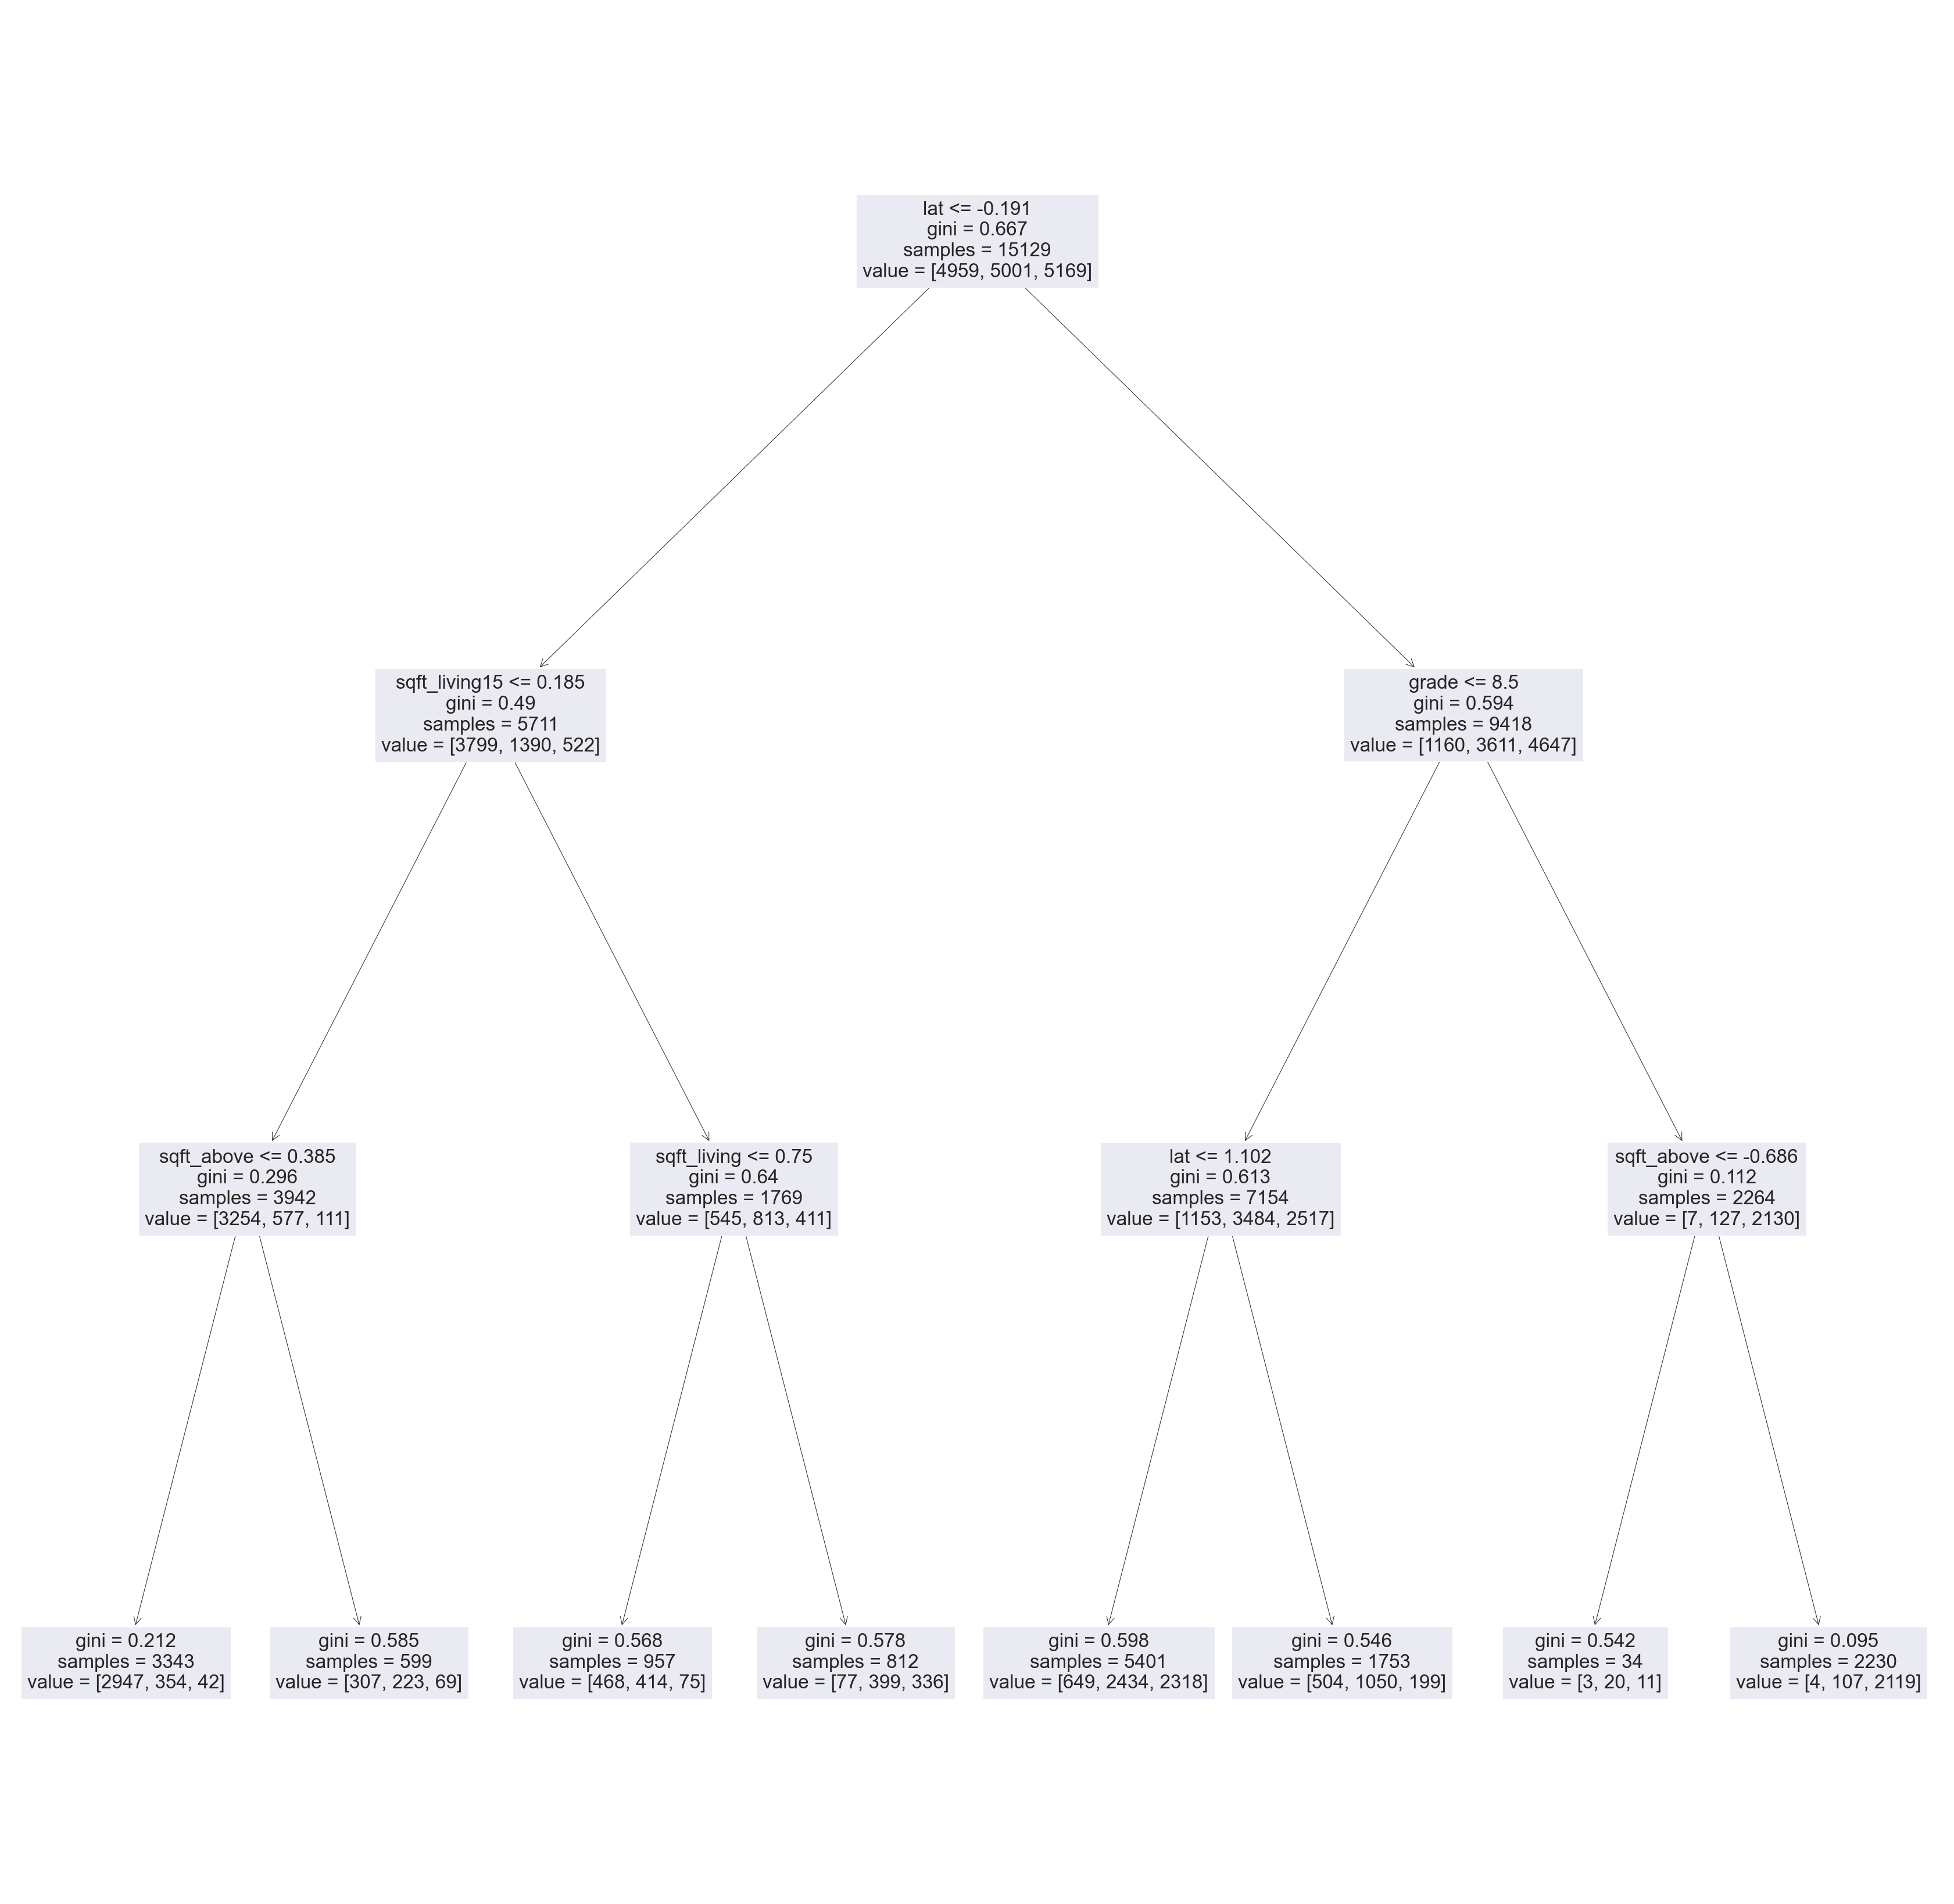

In [30]:
# Train the model once
model = RandomForestClassifier(n_estimators=100, 
                               criterion='gini',
                               max_depth=3, # Avoid overfitting by controling the complexity of the tree
                               max_leaf_nodes=None, # Avoid overfitting by controling the complexity of the tree
                               ccp_alpha=0.0, # Avoid overfitting by pruning the tree
                               min_samples_split=2, # Avoid overfitting by avoid splitting too much
                               min_samples_leaf=1, # Avoid overfitting by avoid splitting too much
                               min_weight_fraction_leaf=0.0, # Avoid overfitting by avoid splitting too much
                               min_impurity_decrease=0.0, # Avoid overfitting by avoid splitting too much
                               max_features='sqrt', # Make sure trees are independent
                               bootstrap=False, # Make sure trees are independent
                               max_samples=None, # Make sure trees are independent
                               oob_score=False,
                               class_weight=None,
                               n_jobs=-1,
                               random_state=0).fit(x_train, y_train)

print(model.score(x_train, y_train))
# When boostrap is True, samples may not be equal to the sum of values in each node, as "samples" is the "unique" number of samples, but "value" is the number of "repeated" samples
# https://stackoverflow.com/questions/56103507/why-does-this-decision-trees-values-at-each-step-not-sum-to-the-number-of-sampl
plt.rcParams["figure.figsize"] = (60, 60)
tree.plot_tree(model.estimators_[0], feature_names=x_train.columns)  # Visualize one of the trees in the random forest
plt.show()

,feature,importance_score
12,lat,0.349271
6,sqft_living,0.189008
3,grade,0.161086
14,sqft_living15,0.104897
9,sqft_above,0.082450
5,bathrooms,0.039454
4,bedrooms,0.019760
15,sqft_lot15,0.012127
11,yr_built,0.011867
10,sqft_basement,0.008326


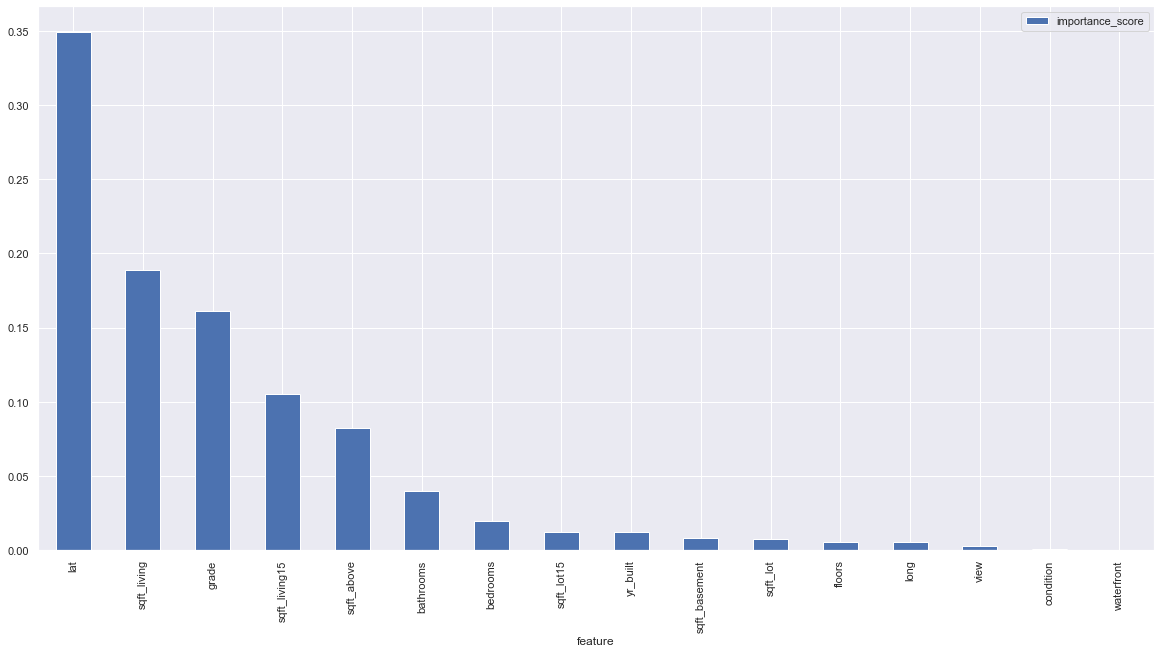

In [24]:
df_importance = pd.concat((pd.Series(x_train.columns), pd.Series(model.feature_importances_)), axis=1)
df_importance.columns = ['feature', 'importance_score']
df_importance = df_importance.sort_values(by='importance_score', ascending=False)
df_importance.plot(x='feature', y='importance_score', kind='bar', figsize=(20, 10))
df_importance

### Train the model and search hyperparameters by CV

In [31]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_multi_metric_evaluation.html#sphx-glr-auto-examples-model-selection-plot-multi-metric-evaluation-py
# rank_test_score indicates the rank of a grid search parameter combination based on the mean_test_score

param_grid = [
    {'n_estimators': [100, 200], 
     'criterion': ['gini', 'entropy'], 
     'max_depth': [3, 6], 
     'min_samples_split': [2, 10],
     'min_samples_leaf': [1, 5],
     'min_impurity_decrease': [0, 0.02],
     'class_weight': [{0: 1.2, 1: 1.0, 2: 1.0}, 'balanced']}
]

def precision_2(y_true, y_pred):
    return precision_score(y_true, y_pred, average=None)[2]
def recall_2(y_true, y_pred):
    return recall_score(y_true, y_pred, average=None)[2]
def multiclass_auc(y_true, y_prob):
    return roc_auc_score(y_true, y_prob, multi_class='ovo', average='macro')
auc_scorer = make_scorer(multiclass_auc, needs_proba=True, greater_is_better=True)  # multiclass_auc requires to accept y_prob as input, so we need to set needs_proba=True
accuracy_scorer = make_scorer(accuracy_score, greater_is_better=True)
precision_scorer = make_scorer(precision_2, greater_is_better=True)
recall_scorer = make_scorer(recall_2, greater_is_better=True)
scoring = {'AUC': auc_scorer, 'Accuracy': accuracy_scorer, 'Precision': precision_scorer, 'Recall': recall_scorer}

rs = RandomizedSearchCV(
    RandomForestClassifier(random_state=0),
    param_distributions=param_grid,
    n_iter=30,
    scoring=scoring,
    refit='AUC',
    return_train_score=False,
    cv=5, n_jobs=-1, random_state=0
)
rs.fit(x_train, y_train)

model = rs.best_estimator_
print(rs.best_estimator_)
print(rs.best_params_)

result = rs.cv_results_
list(result.keys())

RandomForestClassifier(class_weight={0: 1.2, 1: 1.0}, max_depth=6,
                       min_impurity_decrease=0, min_samples_leaf=5,
                       min_samples_split=10, random_state=0)
{'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 5, 'min_impurity_decrease': 0, 'max_depth': 6, 'criterion': 'gini', 'class_weight': {0: 1.2, 1: 1.0}}


['mean_fit_time',
 'std_fit_time',
 'mean_score_time',
 'std_score_time',
 'param_n_estimators',
 'param_min_samples_split',
 'param_min_samples_leaf',
 'param_min_impurity_decrease',
 'param_max_depth',
 'param_criterion',
 'param_class_weight',
 'params',
 'split0_test_AUC',
 'split1_test_AUC',
 'split2_test_AUC',
 'split3_test_AUC',
 'split4_test_AUC',
 'mean_test_AUC',
 'std_test_AUC',
 'rank_test_AUC',
 'split0_test_Accuracy',
 'split1_test_Accuracy',
 'split2_test_Accuracy',
 'split3_test_Accuracy',
 'split4_test_Accuracy',
 'mean_test_Accuracy',
 'std_test_Accuracy',
 'rank_test_Accuracy',
 'split0_test_Precision',
 'split1_test_Precision',
 'split2_test_Precision',
 'split3_test_Precision',
 'split4_test_Precision',
 'mean_test_Precision',
 'std_test_Precision',
 'rank_test_Precision',
 'split0_test_Recall',
 'split1_test_Recall',
 'split2_test_Recall',
 'split3_test_Recall',
 'split4_test_Recall',
 'mean_test_Recall',
 'std_test_Recall',
 'rank_test_Recall']

In [32]:
df_params = pd.DataFrame(result['params'])
df_metrics = pd.DataFrame({k: result[k] for k in ['mean_test_AUC', 'std_test_AUC', 'mean_test_Accuracy', 'std_test_Accuracy', 'mean_test_Precision', 'std_test_Precision', 'mean_test_Recall', 'std_test_Recall']})
df_cv = pd.concat((df_params, df_metrics), axis=1).sort_values(by=['mean_test_AUC', 'mean_test_Accuracy', 'mean_test_Precision', 'mean_test_Recall'], ascending=False)
df_cv

,n_estimators,min_samples_split,min_samples_leaf,min_impurity_decrease,max_depth,criterion,class_weight,mean_test_AUC,std_test_AUC,mean_test_Accuracy,std_test_Accuracy,mean_test_Precision,std_test_Precision,mean_test_Recall,std_test_Recall
20,100,10,5,0.00,6,gini,"{0: 1.2, 1: 1.0}",0.929017,0.004557,0.789874,0.011637,0.866849,0.006913,0.799961,0.019335
27,100,2,1,0.00,6,gini,"{0: 1.2, 1: 1.0}",0.928859,0.004179,0.789741,0.011547,0.867698,0.008078,0.800542,0.019579
2,100,10,5,0.00,6,gini,balanced,0.928752,0.004021,0.788552,0.008236,0.872903,0.006097,0.791837,0.017001
3,200,10,1,0.00,6,entropy,"{0: 1.2, 1: 1.0}",0.928611,0.003773,0.788817,0.009752,0.859749,0.009890,0.810795,0.014911
18,100,10,1,0.00,6,entropy,"{0: 1.2, 1: 1.0}",0.928609,0.003601,0.789147,0.009184,0.858446,0.009585,0.811570,0.014597
22,100,2,1,0.00,6,entropy,"{0: 1.2, 1: 1.0}",0.928426,0.003402,0.788288,0.009555,0.859791,0.006669,0.809247,0.018105
29,100,10,5,0.00,6,entropy,balanced,0.928315,0.003804,0.786635,0.010102,0.864153,0.007916,0.800155,0.016967
6,200,10,5,0.02,6,entropy,balanced,0.888778,0.004780,0.721197,0.010780,0.803838,0.008747,0.762429,0.013207
24,200,2,1,0.02,6,entropy,balanced,0.888778,0.004780,0.721197,0.010780,0.803838,0.008747,0.762429,0.013207
7,100,2,1,0.00,3,entropy,balanced,0.888666,0.005004,0.730385,0.008484,0.814196,0.007166,0.764558,0.012907


### Evaluation

In [33]:
proba_pred = model.predict_proba(x_test)
y_pred = model.predict(x_test)
acc_test = model.score(x_test, y_test)

assert (proba_pred.argmax(axis=1) == y_pred).all()
assert acc_test == accuracy_score(y_test, y_pred) == (y_test == pd.Series(y_pred)).mean()

In [ ]:
print(classification_report(y_test, y_pred, target_names=['class 0', 'class 1', 'class 2']))

In [ ]:
get_confusion_matrix(y_test, y_pred, n_labels=3)

## GBDT + multiple classification

### Train the model once

0.851279000594884


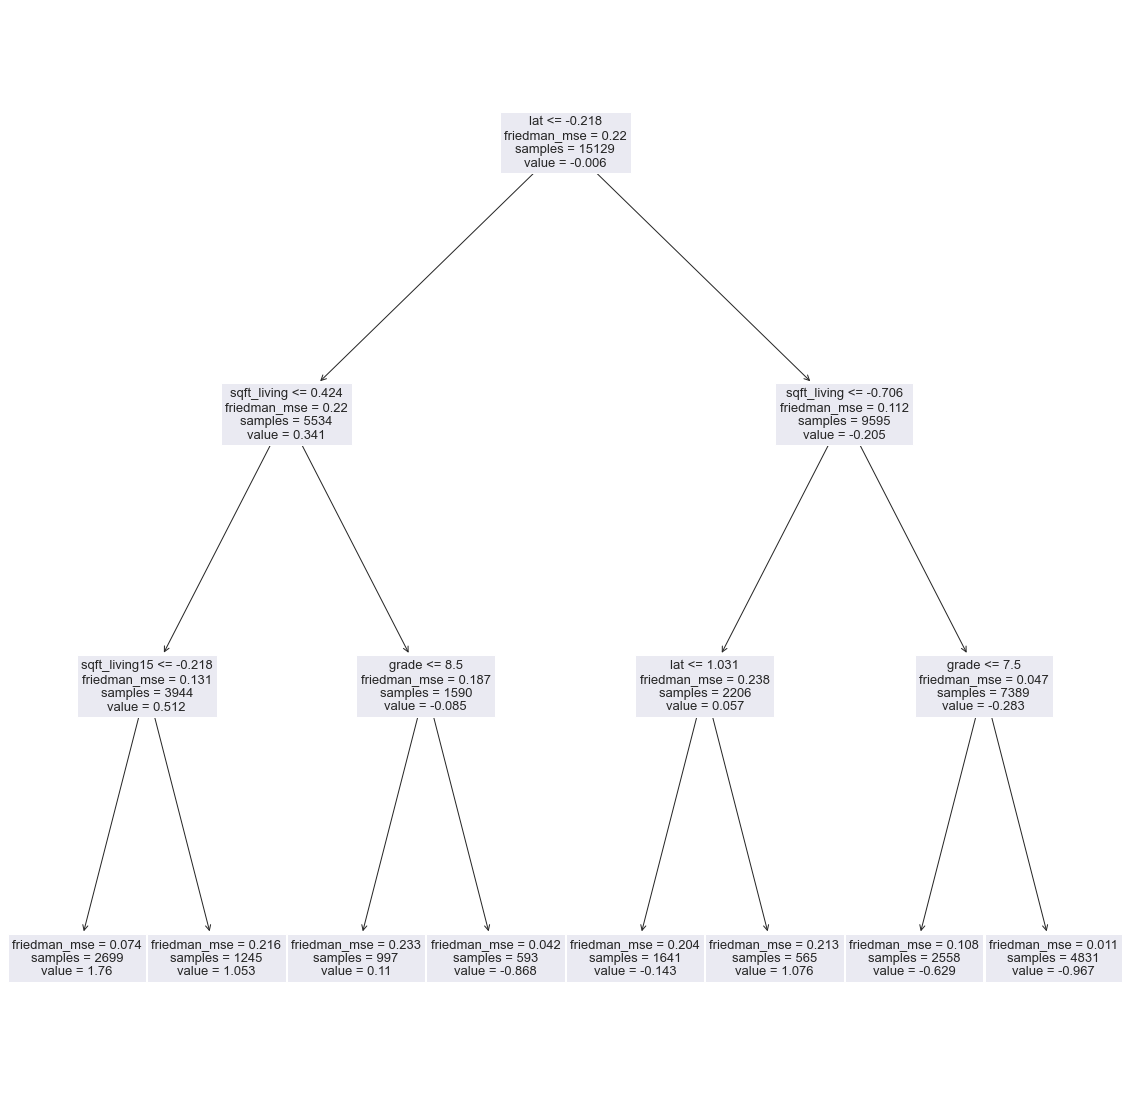

In [13]:
# Train the model once
model = GradientBoostingClassifier(loss='deviance',  # binomial or multinomial deviance loss function
                                   learning_rate=0.1, # Learning rate shrinks the contribution of each tree by learning_rate. The larger the learning rate is, the fewer estimators we need
                                   n_estimators=100, # Gradient boosting is fairly robust to over-fitting so a large number usually results in better performance
                                   criterion='friedman_mse',
                                   init='zero', # An estimator object that is used to compute the initial predictions
                                   max_depth=3, # Avoid overfitting by controling the complexity of the tree
                                   max_leaf_nodes=None, # Avoid overfitting by controling the complexity of the tree
                                   ccp_alpha=0.0, # Avoid overfitting by pruning the tree
                                   min_samples_split=2, # Avoid overfitting by avoid splitting too much
                                   min_samples_leaf=1, # Avoid overfitting by avoid splitting too much
                                   min_weight_fraction_leaf=0.0, # Avoid overfitting by avoid splitting too much
                                   min_impurity_decrease=0.0, # Avoid overfitting by avoid splitting too much
                                   subsample=1.0,  # The fraction of samples to be used for fitting the individual base learners. If smaller than 1.0 this results in Stochastic Gradient Boosting. subsample interacts with the parameter n_estimators. Choosing subsample < 1.0 leads to a reduction of variance and an increase in bias
                                   max_features=None, # Make sure trees are independent
                                   random_state=0).fit(x_train, y_train)

print(model.score(x_train, y_train))
tree.plot_tree(model.estimators_[0][0], feature_names=x_train.columns)  # Visualize one of the trees in the random forest, where now model.estimators_ is an array of size n_estimators * loss_.K
plt.show()

,feature,importance_score
12,lat,0.427680
6,sqft_living,0.232787
3,grade,0.184047
13,long,0.032486
14,sqft_living15,0.030398
7,sqft_lot,0.025411
11,yr_built,0.017966
15,sqft_lot15,0.015744
9,sqft_above,0.015372
1,view,0.009769


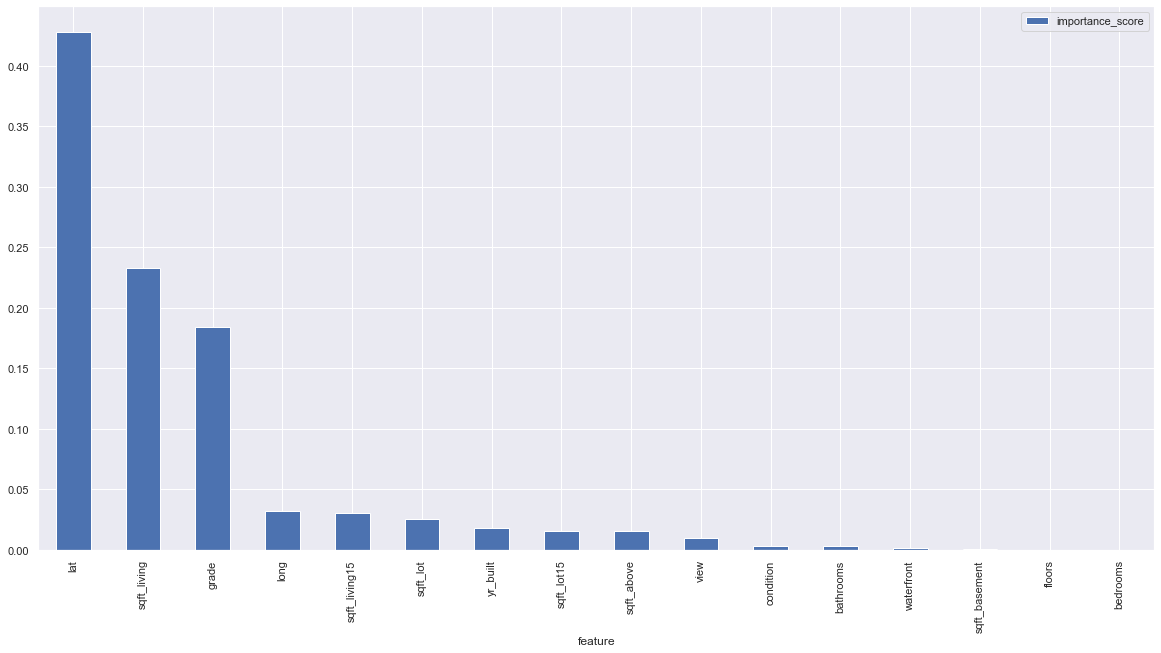

In [14]:
df_importance = pd.concat((pd.Series(x_train.columns), pd.Series(model.feature_importances_)), axis=1)
df_importance.columns = ['feature', 'importance_score']
df_importance = df_importance.sort_values(by='importance_score', ascending=False)
df_importance.plot(x='feature', y='importance_score', kind='bar', figsize=(20, 10))
df_importance

### Train the model and search hyperparameters by CV

In [25]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_multi_metric_evaluation.html#sphx-glr-auto-examples-model-selection-plot-multi-metric-evaluation-py
# rank_test_score indicates the rank of a grid search parameter combination based on the mean_test_score

param_grid = [
    {'learning_rate': [0.01, 0.1],
     'n_estimators': [50, 100], 
     'max_depth': [3, 6], 
     'min_samples_split': [2, 10],
     'min_samples_leaf': [1, 5],
     'min_impurity_decrease': [0, 0.02], 
     'subsample': [1, 0.8]}
]

def precision_2(y_true, y_pred):
    return precision_score(y_true, y_pred, average=None)[2]
def recall_2(y_true, y_pred):
    return recall_score(y_true, y_pred, average=None)[2]
def multiclass_auc(y_true, y_prob):
    return roc_auc_score(y_true, y_prob, multi_class='ovo', average='macro')
auc_scorer = make_scorer(multiclass_auc, needs_proba=True, greater_is_better=True)  # multiclass_auc requires to accept y_prob as input, so we need to set needs_proba=True
accuracy_scorer = make_scorer(accuracy_score, greater_is_better=True)
precision_scorer = make_scorer(precision_2, greater_is_better=True)
recall_scorer = make_scorer(recall_2, greater_is_better=True)
scoring = {'AUC': auc_scorer, 'Accuracy': accuracy_scorer, 'Precision': precision_scorer, 'Recall': recall_scorer}

rs = RandomizedSearchCV(
    GradientBoostingClassifier(random_state=0),
    param_distributions=param_grid,
    n_iter=10,
    scoring=scoring,
    refit='AUC',
    return_train_score=False,
    cv=5, n_jobs=-1, random_state=0
)
rs.fit(x_train, y_train)

model = rs.best_estimator_
print(rs.best_estimator_)
print(rs.best_params_)

result = rs.cv_results_
list(result.keys())

GradientBoostingClassifier(max_depth=6, min_impurity_decrease=0.02,
                           min_samples_leaf=5, min_samples_split=10,
                           random_state=0, subsample=0.8)
{'subsample': 0.8, 'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 5, 'min_impurity_decrease': 0.02, 'max_depth': 6, 'learning_rate': 0.1}


['mean_fit_time',
 'std_fit_time',
 'mean_score_time',
 'std_score_time',
 'param_subsample',
 'param_n_estimators',
 'param_min_samples_split',
 'param_min_samples_leaf',
 'param_min_impurity_decrease',
 'param_max_depth',
 'param_learning_rate',
 'params',
 'split0_test_AUC',
 'split1_test_AUC',
 'split2_test_AUC',
 'split3_test_AUC',
 'split4_test_AUC',
 'mean_test_AUC',
 'std_test_AUC',
 'rank_test_AUC',
 'split0_test_Accuracy',
 'split1_test_Accuracy',
 'split2_test_Accuracy',
 'split3_test_Accuracy',
 'split4_test_Accuracy',
 'mean_test_Accuracy',
 'std_test_Accuracy',
 'rank_test_Accuracy',
 'split0_test_Precision',
 'split1_test_Precision',
 'split2_test_Precision',
 'split3_test_Precision',
 'split4_test_Precision',
 'mean_test_Precision',
 'std_test_Precision',
 'rank_test_Precision',
 'split0_test_Recall',
 'split1_test_Recall',
 'split2_test_Recall',
 'split3_test_Recall',
 'split4_test_Recall',
 'mean_test_Recall',
 'std_test_Recall',
 'rank_test_Recall']

In [26]:
df_params = pd.DataFrame(result['params'])
df_metrics = pd.DataFrame({k: result[k] for k in ['mean_test_AUC', 'std_test_AUC', 'mean_test_Accuracy', 'std_test_Accuracy', 'mean_test_Precision', 'std_test_Precision', 'mean_test_Recall', 'std_test_Recall']})
df_cv = pd.concat((df_params, df_metrics), axis=1).sort_values(by=['mean_test_AUC', 'mean_test_Accuracy', 'mean_test_Precision', 'mean_test_Recall'], ascending=False)
df_cv

,subsample,n_estimators,min_samples_split,min_samples_leaf,min_impurity_decrease,max_depth,learning_rate,mean_test_AUC,std_test_AUC,mean_test_Accuracy,std_test_Accuracy,mean_test_Precision,std_test_Precision,mean_test_Recall,std_test_Recall
6,0.8,100,10,5,0.02,6,0.10,0.954967,0.001769,0.839382,0.004801,0.883231,0.006742,0.868641,0.007799
7,1.0,50,2,1,0.00,6,0.10,0.952478,0.002375,0.834027,0.004556,0.882078,0.007474,0.863419,0.010694
5,1.0,50,10,5,0.00,6,0.10,0.952343,0.002478,0.831978,0.005667,0.879986,0.007584,0.860518,0.011945
2,1.0,100,10,1,0.02,3,0.10,0.947335,0.002990,0.824707,0.006612,0.880591,0.013784,0.848715,0.012824
3,0.8,100,2,1,0.02,6,0.01,0.942422,0.002542,0.815718,0.005280,0.866183,0.008756,0.849294,0.012194
8,0.8,50,2,5,0.00,3,0.10,0.940511,0.003034,0.809373,0.004625,0.871634,0.011521,0.832658,0.013848
0,1.0,50,2,5,0.00,6,0.01,0.933721,0.002801,0.798797,0.004462,0.836148,0.010281,0.850454,0.011538
9,0.8,100,10,1,0.00,3,0.01,0.911917,0.004039,0.763699,0.008042,0.838241,0.009395,0.804798,0.015681
1,1.0,50,2,5,0.02,3,0.01,0.897286,0.003585,0.745522,0.002636,0.803356,0.010373,0.815246,0.010285
4,1.0,50,2,5,0.00,3,0.01,0.897286,0.003585,0.745522,0.002636,0.803356,0.010373,0.815246,0.010285


### Evaluation

In [27]:
proba_pred = model.predict_proba(x_test)
y_pred = model.predict(x_test)
acc_test = model.score(x_test, y_test)

assert (proba_pred.argmax(axis=1) == y_pred).all()
assert acc_test == accuracy_score(y_test, y_pred) == (y_test == pd.Series(y_pred)).mean()

In [ ]:
print(classification_report(y_test, y_pred, target_names=['class 0', 'class 1', 'class 2']))

In [ ]:
get_confusion_matrix(y_test, y_pred, n_labels=3)

## Linear model + regression 

### Train the model once

In [64]:
# Train the model once
"""
a * ||w||_1 + 0.5 * b * ||w||_2^2
alpha = a + b and l1_ratio = a / (a + b)
"""
model = ElasticNet(alpha=1, l1_ratio=0.5, fit_intercept=True, 
                   random_state=0, tol=1e-4, max_iter=1000).fit(x_train, y_train)  

print(model.score(x_train, y_train))
model.coef_

0.41261235998123835


array([ 0.        ,  0.26209985,  0.58313944,  0.        ,  0.        ,
        0.27146653,  0.01041404, -0.        ,  0.38205399, -0.        ,
        0.57134722,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -0.        , -0.        ,  0.        ,
        0.        ,  0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ])

### Train the model and search hyperparameters by CV

In [8]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_multi_metric_evaluation.html#sphx-glr-auto-examples-model-selection-plot-multi-metric-evaluation-py
# rank_test_score indicates the rank of a grid search parameter combination based on the mean_test_score

param_grid = [
    {'alpha': list(np.arange(0.001, 1, 0.05)), 'l1_ratio': list(np.arange(0, 1, 0.01))},  # In my case, alpha should not be too small, otherwise the matrix is singular and the optimization algorithm doesn't converge
]

scoring = {'MSE': make_scorer(mean_squared_error, greater_is_better=False)}  # As you can see in df_cv, make_scorer will multiply -1 to MSE 

rs = RandomizedSearchCV(
    ElasticNet(random_state=0),
    param_distributions=param_grid,
    n_iter=2000,
    scoring=scoring,
    refit='MSE',
    return_train_score=False,
    cv=5, n_jobs=-1, random_state=0
)
rs.fit(x_train, y_train)

model = rs.best_estimator_
print(rs.best_estimator_)
print(rs.best_params_)

result = rs.cv_results_
list(result.keys())

ElasticNet(alpha=0.001, l1_ratio=0.9500000000000001, random_state=0)
{'l1_ratio': 0.9500000000000001, 'alpha': 0.001}


['mean_fit_time',
 'std_fit_time',
 'mean_score_time',
 'std_score_time',
 'param_l1_ratio',
 'param_alpha',
 'params',
 'split0_test_MSE',
 'split1_test_MSE',
 'split2_test_MSE',
 'split3_test_MSE',
 'split4_test_MSE',
 'mean_test_MSE',
 'std_test_MSE',
 'rank_test_MSE']

In [9]:
df_params = pd.DataFrame(result['params'])
df_metrics = pd.DataFrame({k: result[k] for k in ['mean_test_MSE', 'std_test_MSE']})
df_cv = pd.concat((df_params, df_metrics), axis=1).sort_values(by=['mean_test_MSE'], ascending=False)
df_cv

,l1_ratio,alpha,mean_test_MSE,std_test_MSE
95,0.95,0.001,-3.825515,0.424545
94,0.94,0.001,-3.825547,0.426444
96,0.96,0.001,-3.825588,0.422563
93,0.93,0.001,-3.825675,0.428265
97,0.97,0.001,-3.825775,0.420495
...,...,...,...,...
1995,0.95,0.951,-8.530734,1.000764
1996,0.96,0.951,-8.549666,1.002379
1997,0.97,0.951,-8.569050,1.004015
1998,0.98,0.951,-8.588909,1.005669


### Evaluation

In [ ]:
y_pred = model.predict(x_test)
print(mean_squared_error(y_test, y_pred))
df_predict = pd.concat((y_test, pd.Series(y_pred)), axis=1)
df_predict

## Random forest + regression 

### Train the model once

0.6689376163425771


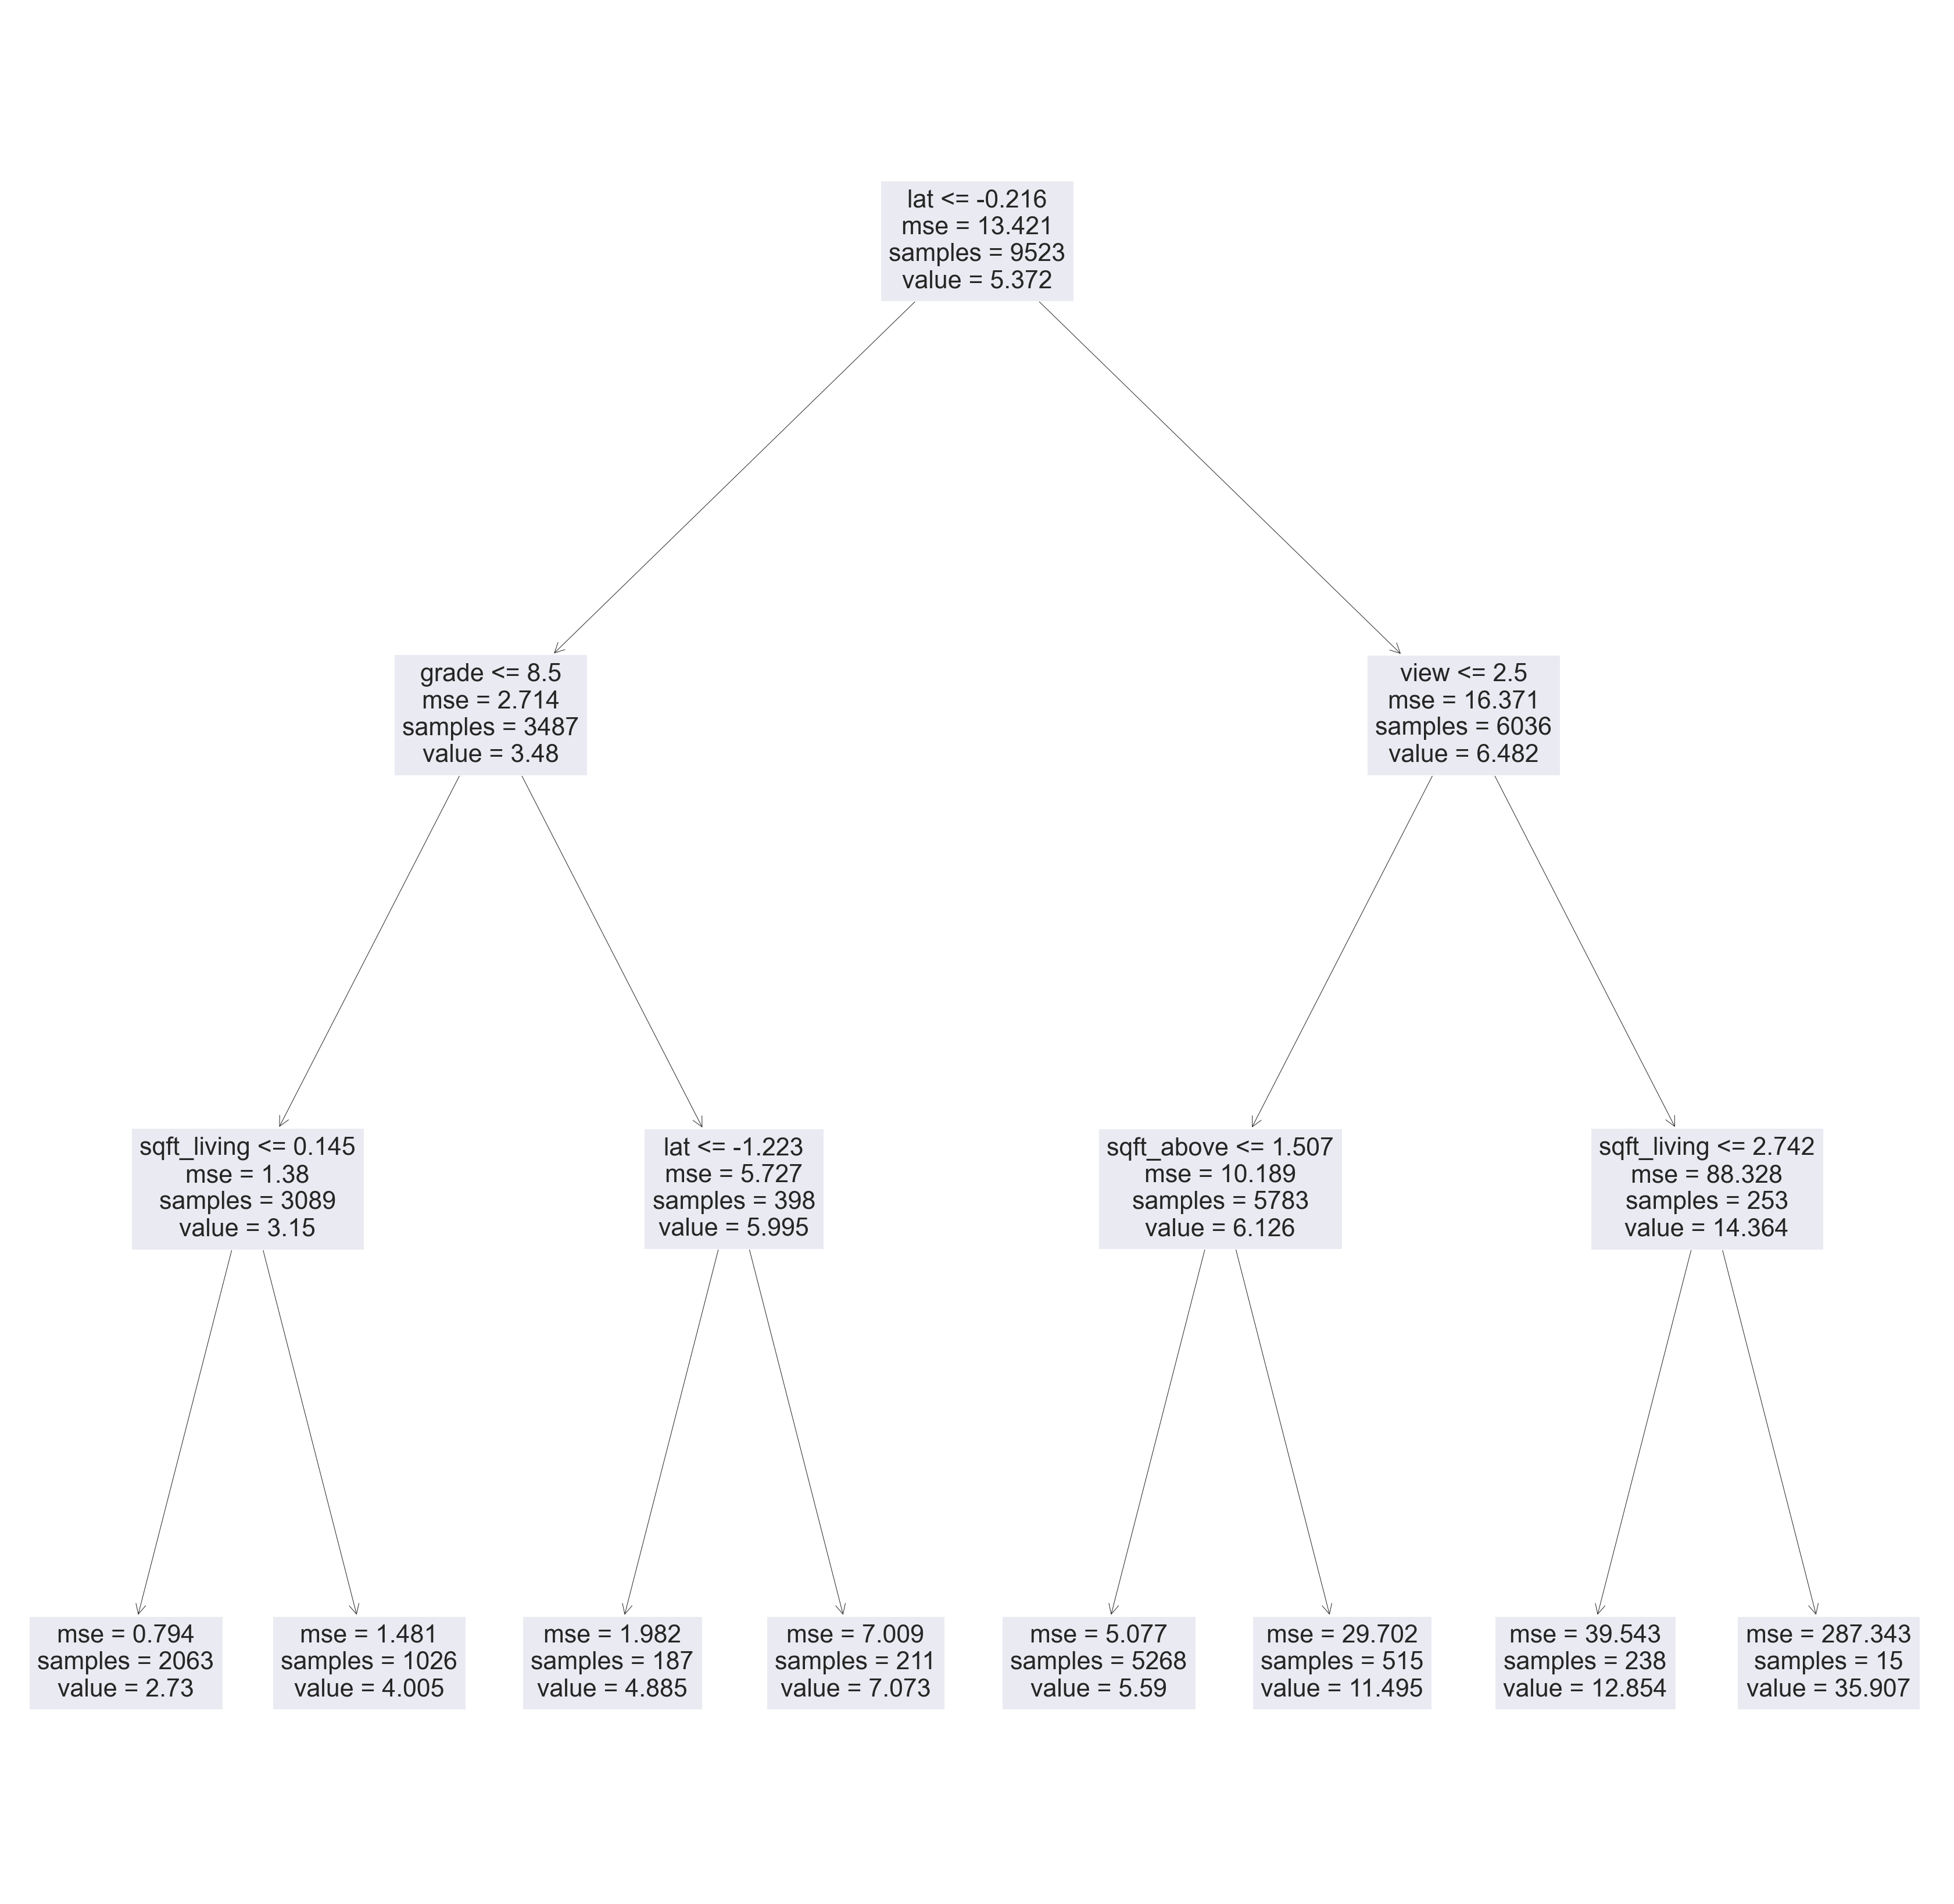

In [39]:
# Train the model once
model = RandomForestRegressor(n_estimators=100, 
                               criterion='mse',
                               max_depth=3, # Avoid overfitting by controling the complexity of the tree
                               max_leaf_nodes=None, # Avoid overfitting by controling the complexity of the tree
                               ccp_alpha=0.0, # Avoid overfitting by pruning the tree
                               min_samples_split=2, # Avoid overfitting by avoid splitting too much
                               min_samples_leaf=1, # Avoid overfitting by avoid splitting too much
                               min_weight_fraction_leaf=0.0, # Avoid overfitting by avoid splitting too much
                               min_impurity_decrease=0.0, # Avoid overfitting by avoid splitting too much
                               max_features=1 / 3, # Make sure trees are independent
                               bootstrap=True, # Make sure trees are independent
                               max_samples=None, # Make sure trees are independent
                               oob_score=True,
                               n_jobs=-1,
                               random_state=0).fit(x_train, y_train)

print(model.score(x_train, y_train))
# When boostrap is True, samples may not be equal to the sum of values in each node, as "samples" is the "unique" number of samples, but "value" is the number of "repeated" samples
# https://stackoverflow.com/questions/56103507/why-does-this-decision-trees-values-at-each-step-not-sum-to-the-number-of-sampl
plt.rcParams["figure.figsize"] = (60, 60)
tree.plot_tree(model.estimators_[0], feature_names=x_train.columns)  # Visualize one of the trees in the random forest
plt.show()

,feature,importance_score
6,sqft_living,0.284230
3,grade,0.257672
14,sqft_living15,0.111010
12,lat,0.101442
9,sqft_above,0.086874
5,bathrooms,0.063501
1,view,0.036078
0,waterfront,0.020141
10,sqft_basement,0.013398
13,long,0.013018


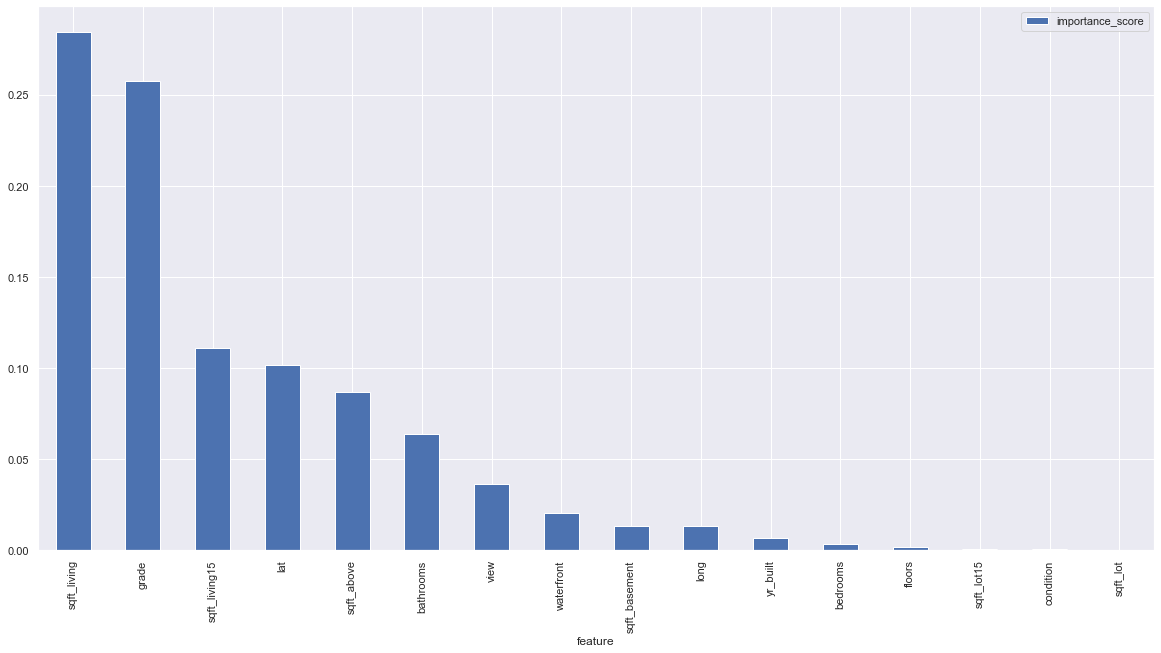

In [40]:
df_importance = pd.concat((pd.Series(x_train.columns), pd.Series(model.feature_importances_)), axis=1)
df_importance.columns = ['feature', 'importance_score']
df_importance = df_importance.sort_values(by='importance_score', ascending=False)
df_importance.plot(x='feature', y='importance_score', kind='bar', figsize=(20, 10))
df_importance

### Train the model and search hyperparameters by CV

In [13]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_multi_metric_evaluation.html#sphx-glr-auto-examples-model-selection-plot-multi-metric-evaluation-py
# rank_test_score indicates the rank of a grid search parameter combination based on the mean_test_score

param_grid = [
    {'n_estimators': [100, 200], 
     'criterion': ['mse'], # Using 'mae' here will make the following CV very slow, I don't know why
     'max_depth': [3, 6], 
     'min_samples_split': [2, 10],
     'min_samples_leaf': [1, 5],
     'min_impurity_decrease': [0, 0.02]}
]

scoring = {'MSE': make_scorer(mean_squared_error, greater_is_better=False)}  # As you can see in df_cv, make_scorer will multiply -1 to MSE 

rs = RandomizedSearchCV(
    RandomForestRegressor(random_state=0, max_features=1 / 3),
    param_distributions=param_grid,
    n_iter=10,
    scoring=scoring,
    refit='MSE',
    return_train_score=False,
    cv=5, n_jobs=-1, random_state=0
)
rs.fit(x_train, y_train)

model = rs.best_estimator_
print(rs.best_estimator_)
print(rs.best_params_)

result = rs.cv_results_
list(result.keys())

RandomForestRegressor(max_depth=6, max_features=0.3333333333333333,
                      min_impurity_decrease=0, min_samples_leaf=5,
                      min_samples_split=10, random_state=0)
{'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 5, 'min_impurity_decrease': 0, 'max_depth': 6, 'criterion': 'mse'}


['mean_fit_time',
 'std_fit_time',
 'mean_score_time',
 'std_score_time',
 'param_n_estimators',
 'param_min_samples_split',
 'param_min_samples_leaf',
 'param_min_impurity_decrease',
 'param_max_depth',
 'param_criterion',
 'params',
 'split0_test_MSE',
 'split1_test_MSE',
 'split2_test_MSE',
 'split3_test_MSE',
 'split4_test_MSE',
 'mean_test_MSE',
 'std_test_MSE',
 'rank_test_MSE']

In [14]:
df_params = pd.DataFrame(result['params'])
df_metrics = pd.DataFrame({k: result[k] for k in ['mean_test_MSE', 'std_test_MSE']})
df_cv = pd.concat((df_params, df_metrics), axis=1).sort_values(by=['mean_test_MSE'], ascending=False)
df_cv

,n_estimators,min_samples_split,min_samples_leaf,min_impurity_decrease,max_depth,criterion,mean_test_MSE,std_test_MSE
1,100,10,5,0.00,6,mse,-2.771177,0.307892
8,100,2,5,0.00,6,mse,-2.771177,0.307892
4,100,2,1,0.00,6,mse,-2.799061,0.310225
6,100,2,5,0.02,6,mse,-2.867458,0.323779
7,100,10,1,0.02,6,mse,-2.890287,0.342264
9,200,2,5,0.02,3,mse,-4.625681,0.507088
5,100,10,5,0.02,3,mse,-4.632360,0.521657
0,200,10,1,0.02,3,mse,-4.668883,0.521979
2,100,10,1,0.02,3,mse,-4.676405,0.536539
3,100,10,1,0.00,3,mse,-4.676405,0.536539


### Evaluation

In [ ]:
y_pred = model.predict(x_test)
print(mean_squared_error(y_test, y_pred))
df_predict = pd.concat((y_test, pd.Series(y_pred)), axis=1)
df_predict

## GBDT + regression 

### Train the model once

0.8976688738717221


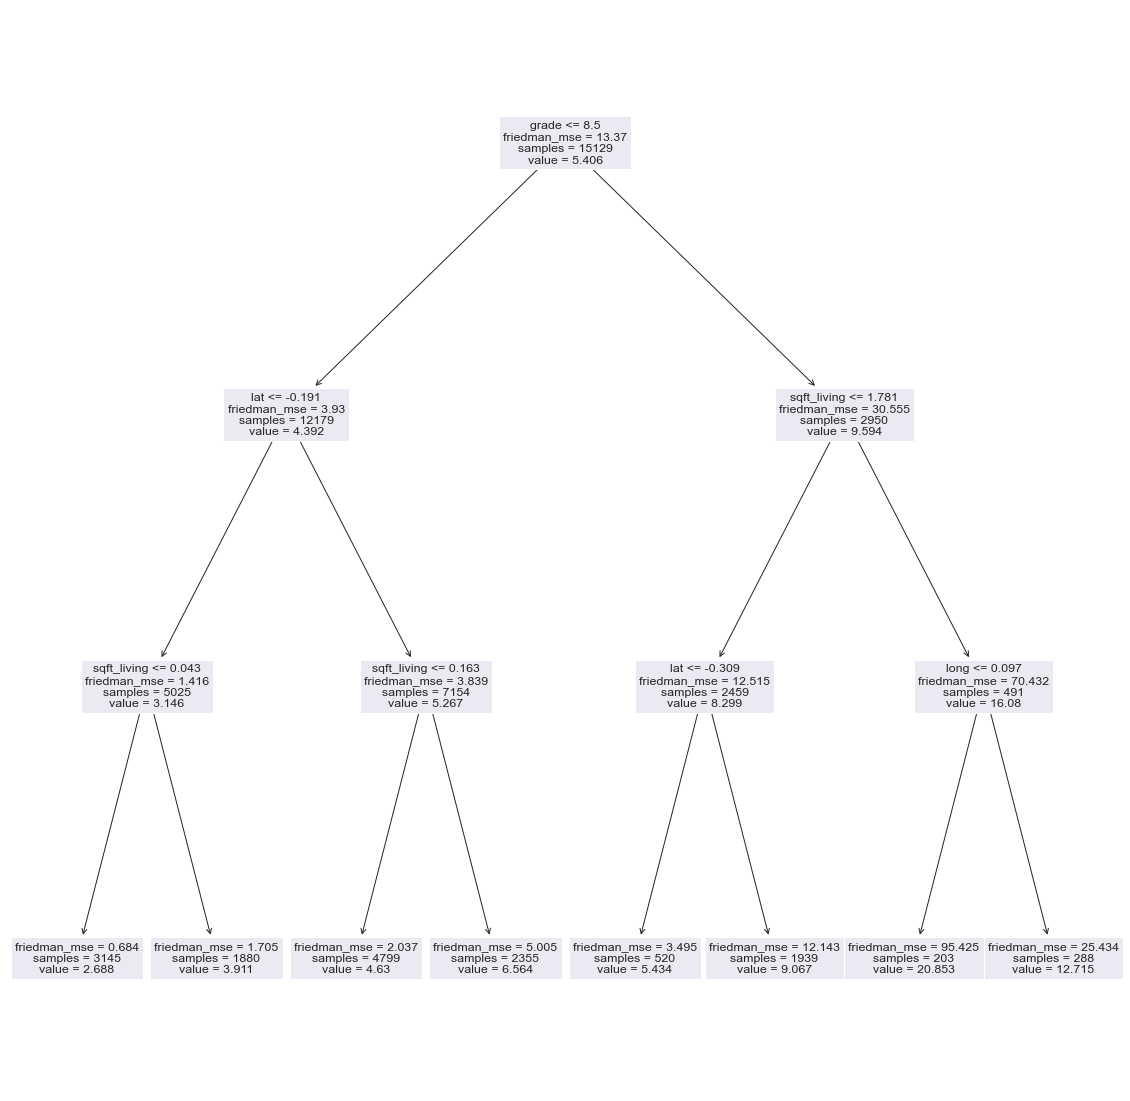

In [18]:
# Train the model once
model = GradientBoostingRegressor(loss='ls', 
                                  learning_rate=0.1, # Learning rate shrinks the contribution of each tree by learning_rate. The larger the learning rate is, the fewer estimators we need
                                  n_estimators=100, # Gradient boosting is fairly robust to over-fitting so a large number usually results in better performance
                                  criterion='friedman_mse',
                                  init='zero', # An estimator object that is used to compute the initial predictions
                                  max_depth=3, # Avoid overfitting by controling the complexity of the tree
                                  max_leaf_nodes=None, # Avoid overfitting by controling the complexity of the tree
                                  ccp_alpha=0.0, # Avoid overfitting by pruning the tree
                                  min_samples_split=2, # Avoid overfitting by avoid splitting too much
                                  min_samples_leaf=1, # Avoid overfitting by avoid splitting too much
                                  min_weight_fraction_leaf=0.0, # Avoid overfitting by avoid splitting too much
                                  min_impurity_decrease=0.0, # Avoid overfitting by avoid splitting too much
                                  subsample=1.0,  # The fraction of samples to be used for fitting the individual base learners. If smaller than 1.0 this results in Stochastic Gradient Boosting. subsample interacts with the parameter n_estimators. Choosing subsample < 1.0 leads to a reduction of variance and an increase in bias
                                  max_features=None, # Make sure trees are independent
                                  random_state=0).fit(x_train, y_train)

print(model.score(x_train, y_train))
tree.plot_tree(model.estimators_[0][0], feature_names=x_train.columns)  # Visualize one of the trees in the random forest, where now model.estimators_ is an array of size n_estimators * loss_.K
plt.show()

,feature,importance_score
6,sqft_living,0.327825
3,grade,0.288917
12,lat,0.168966
13,long,0.068229
0,waterfront,0.040644
11,yr_built,0.029753
14,sqft_living15,0.026254
1,view,0.022751
9,sqft_above,0.009007
10,sqft_basement,0.004949


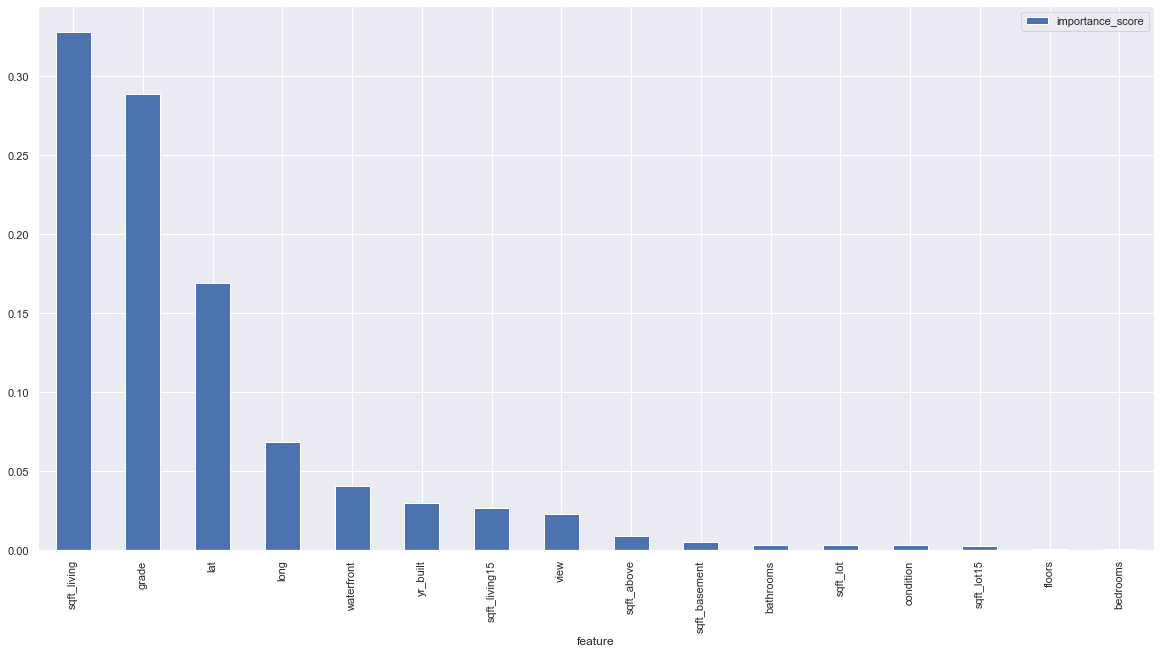

In [19]:
df_importance = pd.concat((pd.Series(x_train.columns), pd.Series(model.feature_importances_)), axis=1)
df_importance.columns = ['feature', 'importance_score']
df_importance = df_importance.sort_values(by='importance_score', ascending=False)
df_importance.plot(x='feature', y='importance_score', kind='bar', figsize=(20, 10))
df_importance

### Train the model and search hyperparameters by CV

In [41]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_multi_metric_evaluation.html#sphx-glr-auto-examples-model-selection-plot-multi-metric-evaluation-py
# rank_test_score indicates the rank of a grid search parameter combination based on the mean_test_score

param_grid = [
    {'learning_rate': [0.01, 0.1],
     'n_estimators': [50, 100], 
     'max_depth': [3, 6], 
     'min_samples_split': [2, 10],
     'min_samples_leaf': [1, 5],
     'min_impurity_decrease': [0, 0.02], 
     'subsample': [1, 0.8]}
]

scoring = {'MSE': make_scorer(mean_squared_error, greater_is_better=False)}  # As you can see in df_cv, make_scorer will multiply -1 to MSE 

rs = RandomizedSearchCV(
    GradientBoostingRegressor(random_state=0),
    param_distributions=param_grid,
    n_iter=10,
    scoring=scoring,
    refit='MSE',
    return_train_score=False,
    cv=5, n_jobs=-1, random_state=0
)
rs.fit(x_train, y_train)

model = rs.best_estimator_
print(rs.best_estimator_)
print(rs.best_params_)

result = rs.cv_results_
list(result.keys())

GradientBoostingRegressor(max_depth=6, min_impurity_decrease=0.02,
                          min_samples_leaf=5, min_samples_split=10,
                          random_state=0, subsample=0.8)
{'subsample': 0.8, 'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 5, 'min_impurity_decrease': 0.02, 'max_depth': 6, 'learning_rate': 0.1}


['mean_fit_time',
 'std_fit_time',
 'mean_score_time',
 'std_score_time',
 'param_subsample',
 'param_n_estimators',
 'param_min_samples_split',
 'param_min_samples_leaf',
 'param_min_impurity_decrease',
 'param_max_depth',
 'param_learning_rate',
 'params',
 'split0_test_MSE',
 'split1_test_MSE',
 'split2_test_MSE',
 'split3_test_MSE',
 'split4_test_MSE',
 'mean_test_MSE',
 'std_test_MSE',
 'rank_test_MSE']

In [42]:
df_params = pd.DataFrame(result['params'])
df_metrics = pd.DataFrame({k: result[k] for k in ['mean_test_MSE', 'std_test_MSE']})
df_cv = pd.concat((df_params, df_metrics), axis=1).sort_values(by=['mean_test_MSE'], ascending=False)
df_cv

,subsample,n_estimators,min_samples_split,min_samples_leaf,min_impurity_decrease,max_depth,learning_rate,mean_test_MSE,std_test_MSE
6,0.8,100,10,5,0.02,6,0.10,-1.645832,0.148119
5,1.0,50,10,5,0.00,6,0.10,-1.717777,0.187639
7,1.0,50,2,1,0.00,6,0.10,-1.749961,0.254109
2,1.0,100,10,1,0.02,3,0.10,-2.015830,0.303228
8,0.8,50,2,5,0.00,3,0.10,-2.227176,0.287220
3,0.8,100,2,1,0.02,6,0.01,-4.059931,0.499354
9,0.8,100,10,1,0.00,3,0.01,-5.516133,0.680217
0,1.0,50,2,5,0.00,6,0.01,-6.799364,0.702449
1,1.0,50,2,5,0.02,3,0.01,-8.002824,0.862635
4,1.0,50,2,5,0.00,3,0.01,-8.002824,0.862635


### Evaluation

In [ ]:
y_pred = model.predict(x_test)
print(mean_squared_error(y_test, y_pred))
df_predict = pd.concat((y_test, pd.Series(y_pred)), axis=1)
df_predict

# Recursive feature elimination (use random forest + binary classification as example)

## Train the model once and get importance scores

0.8527331614779562


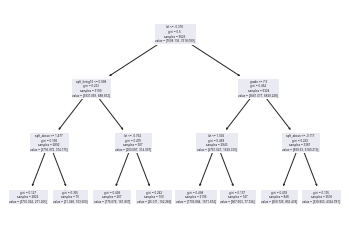

In [5]:
# Train the model once
model = RandomForestClassifier(n_estimators=100, 
                               criterion='gini',
                               max_depth=3, # Avoid overfitting by controling the complexity of the tree
                               max_leaf_nodes=None, # Avoid overfitting by controling the complexity of the tree
                               ccp_alpha=0.0, # Avoid overfitting by pruning the tree
                               min_samples_split=2, # Avoid overfitting by avoid splitting too much
                               min_samples_leaf=1, # Avoid overfitting by avoid splitting too much
                               min_weight_fraction_leaf=0.0, # Avoid overfitting by avoid splitting too much
                               min_impurity_decrease=0.0, # Avoid overfitting by avoid splitting too much
                               max_features='sqrt', # Make sure trees are independent
                               bootstrap=True, # Make sure trees are independent
                               max_samples=None, # Make sure trees are independent
                               oob_score=True,
                               class_weight='balanced',
                               n_jobs=-1,
                               random_state=0).fit(x_train, y_train)

print(model.score(x_train, y_train))
tree.plot_tree(model.estimators_[0], feature_names=x_train.columns)  # Visualize one of the trees in the random forest
plt.show()

,feature,importance_score
12,lat,0.266799
3,grade,0.228779
6,sqft_living,0.219092
14,sqft_living15,0.102032
9,sqft_above,0.072065
5,bathrooms,0.032587
4,bedrooms,0.017811
11,yr_built,0.014481
15,sqft_lot15,0.014244
7,sqft_lot,0.009826


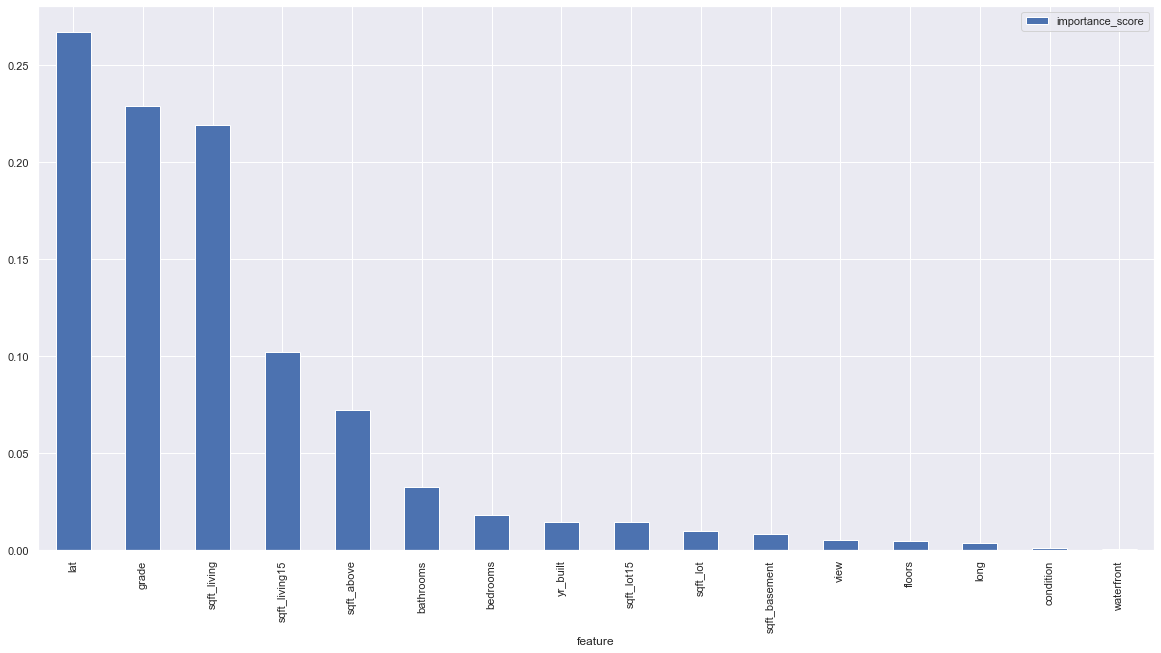

In [6]:
df_importance = pd.concat((pd.Series(x_train.columns), pd.Series(model.feature_importances_)), axis=1)
df_importance.columns = ['feature', 'importance_score']
df_importance = df_importance.sort_values(by='importance_score', ascending=False)
df_importance.plot(x='feature', y='importance_score', kind='bar', figsize=(20, 10))
df_importance

## Conduct RFE

In [7]:
# For now, we didn't do hyperparameter search
# In practice, you should follow the steps mentioned at https://stats.stackexchange.com/a/323899

accuracy_scorer = make_scorer(accuracy_score)
precision_scorer = make_scorer(precision_score, pos_label=1, average='binary')
recall_scorer = make_scorer(recall_score, pos_label=1, average='binary')

all_n_features_selected = list(reversed(range(1, df_importance.shape[0] + 1)))
all_scores = []
for n_features_selected in all_n_features_selected:
    features_selected = df_importance['feature'].iloc[:n_features_selected].tolist()
    scores = cross_val_score(model, 
                             x_train.loc[:, features_selected], 
                             y_train, 
                             scoring='roc_auc',  # can be 'roc_auc', accuracy_scorer, precision_scorer, recall_scorer
                             cv=5, n_jobs=-1, fit_params=None)
    all_scores.append(sum(scores) / len(scores))

,n_features,scores
0,16,0.930754
1,15,0.926335
2,14,0.924247
3,13,0.931276
4,12,0.935675
5,11,0.929414
6,10,0.931963
7,9,0.933907
8,8,0.925925
9,7,0.923211


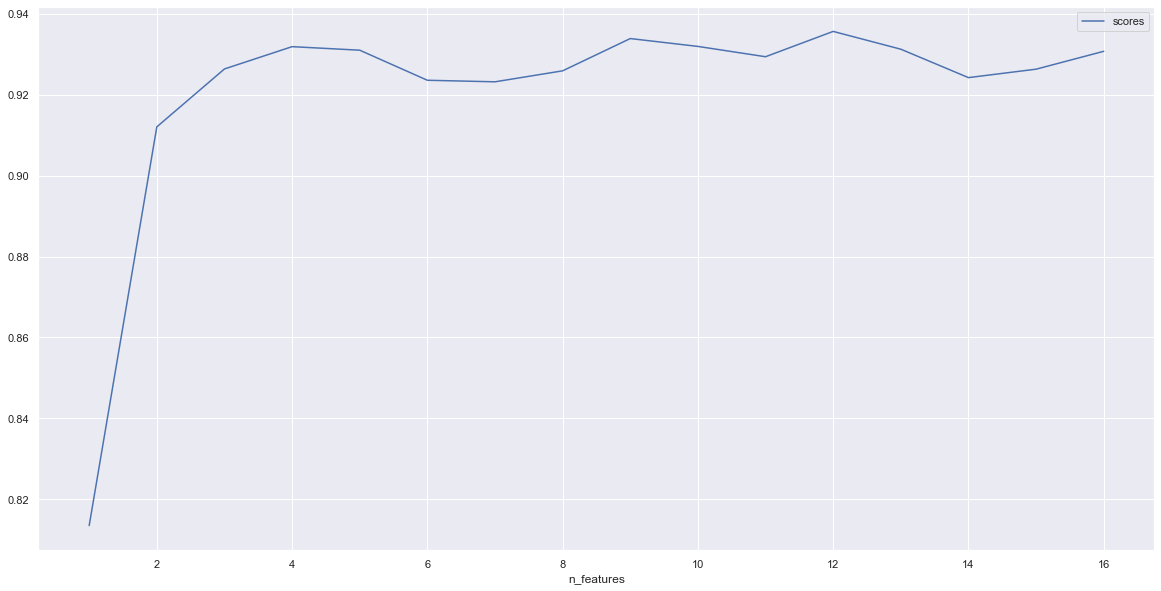

In [8]:
df_rfe = pd.DataFrame({'n_features': all_n_features_selected, 'scores': all_scores})
df_rfe.plot(x='n_features', y='scores', kind='line', figsize=(20, 10))
df_rfe

## Retrain with selected features

['lat', 'grade', 'sqft_living', 'sqft_living15', 'sqft_above', 'bathrooms', 'bedrooms', 'yr_built', 'sqft_lot15', 'sqft_lot', 'sqft_basement', 'view']
0.8526670632559984


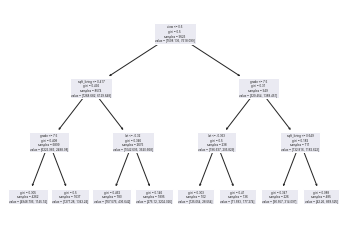

In [9]:
features_selected = df_importance['feature'].iloc[:12].tolist()
x_train_selected = x_train.loc[:, features_selected]
x_test_selected = x_test.loc[:, features_selected]

model = model.fit(x_train_selected, y_train)

print(features_selected)
print(model.score(x_train_selected, y_train))
tree.plot_tree(model.estimators_[0], feature_names=x_train_selected.columns)  # Visualize one of the trees in the random forest
plt.show()

## Evaluation with selected features

In [10]:
proba_pred = model.predict_proba(x_test_selected)
y_pred = model.predict(x_test_selected)
acc_test = model.score(x_test_selected, y_test)

assert (proba_pred.argmax(axis=1) == y_pred).all()
assert acc_test == accuracy_score(y_test, y_pred) == (y_test == pd.Series(y_pred)).mean()

In [ ]:
print(classification_report(y_test, y_pred, target_names=['class 0', 'class 1']))

In [ ]:
get_confusion_matrix(y_test, y_pred, n_labels=2)

In [ ]:
plot_roc_curve(model, x_test_selected, y_test)

In [ ]:
plot_precision_recall_curve(model, x_test_selected, y_test)